# William Shell
# MSDS 692 Data Science Practicum 
# Denver Crime Analysis Project

## Setup and Data Engineering

This section is focused on the following steps create a single useable format for analysis:
1. Environment setup.
2. Ingestion of raw data sets.
3. Null data identification.
4. Imputation as required.
5. Text cleanup.
6. Merging of the data sets into a single dataframe.

### Setting Up The Environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats 
import folium
from folium import plugins
from folium.plugins import HeatMap
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
plt.style.use('fivethirtyeight')

# Create color maps
cmap_green_blue = ListedColormap(['darkolivegreen', 'olive', 'y', 'lightsteelblue','steelblue'])
plot_color = 'steelblue'

The two commands below are commented out for brevity within the file.  Uncommenting them has the effect of forcing Python to show all row and columns rather than the first 10 and final 10 for each output.  Initial analysis of these data was performed with the commands below active.

## Project Description

The Denver Crime Analysis Project aims to create a predictive model of crime using two data sets available from the City of Denver Open Data Catalog, the first being the reported crime statistics and the second being the 2010 Census Data.  Both data sets use neighborhood information which will act as the primary key linking the two data sets enabling a good analysis and modeling.

From the City of Denver Open Data Catalog (located @ https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-crime) this dataset includes criminal offenses in the City and County of Denver for the previous five calendar years plus the current year to date. The data is based on the National Incident Based Reporting System (NIBRS) which includes all victims of person crimes and all crimes within an incident. These data are dynamic, which allows for additions, deletions and/or modifications at any time, resulting in more accurate information in the database. Due to continuous data entry, the number of records in subsequent extractions are subject to change. Crime data is updated Monday through Friday.
 
Also from the City of Denver Open Data Catalog (located @ https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-census-neighborhood-demographics-2010) is a dataset which includes layers from Community Planning and Development with additional demographic information compiled from the 2010 US Census. The City of Denver reports that every effort was made to ensure that blocks were assigned to their proper neighborhoods, due to geographic problems inherent in the original 2010 census block data, errors may exist. This data set includes the housing and population data from redistricting file P.L. 94-171 of the 2010 census. The data-set does not contain data for any enclaves administered by other jurisdictions that are located within the City and County of Denver's boundary.

The project included the following major phases: Data Engineering, Exploratory Data Analysis, Model Creation & Machine Learning, and finally Summary & Results Analysis.

### Import the Raw Data Sets

As noted above, there are three data sets being used in this analysis the crime data from the City of Denver Open Data Catalog, the City of Denver 2010 Census Data, and the City of Denver Offense Codes.

The Crime Dataset contains 512946 observations of the following 19 attributes: 

1. INCIDENT_ID               512946 non-null float64
1. OFFENSE_ID                512946 non-null float64
1. OFFENSE_CODE              512946 non-null int64
1. OFFENSE_CODE_EXTENSION    512946 non-null int64
1. OFFENSE_TYPE_ID           512946 non-null object
1. OFFENSE_CATEGORY_ID       512946 non-null object
1. FIRST_OCCURRENCE_DATE     512946 non-null object
1. LAST_OCCURRENCE_DATE      162450 non-null object
1. REPORTED_DATE             512946 non-null object
1. INCIDENT_ADDRESS          462825 non-null object
1. GEO_X                     508707 non-null float64
1. GEO_Y                     508707 non-null float64
1. GEO_LON                   508707 non-null float64
1. GEO_LAT                   508707 non-null float64
1. DISTRICT_ID               512946 non-null int64
1. PRECINCT_ID               512946 non-null int64
1. NEIGHBORHOOD_ID           512946 non-null object
1. IS_CRIME                  512946 non-null int64
1. IS_TRAFFIC                512946 non-null int64

The Census Dataset contains 78 observations of 127 different attributes.  For the sake of brevity, the 127 attributes are listed here but generally include information that identifies neighborhoods, resident gender, resident ethnicity, housing, resident age categories, and other demographic data.

The final dataset is the Crime Codes Dataset which contains 299 observations of the following 8 attributes:

1. OFFENSE_CODE              299 non-null int64
1. OFFENSE_CODE_EXTENSION    299 non-null int64
1. OFFENSE_TYPE_ID           299 non-null object
1. OFFENSE_TYPE_NAME         299 non-null object
1. OFFENSE_CATEGORY_ID       299 non-null object
1. OFFENSE_CATEGORY_NAME     299 non-null object
1. IS_CRIME                  299 non-null int64
1. IS_TRAFFIC                299 non-null int64

In [2]:
crimeData  = pd.read_csv('crime_091619.csv',sep=',')
censusData = pd.read_csv('census_neighborhood_demographics_2010.csv',sep=',')
codesData  = pd.read_csv('offense_codes_091619.csv')

Confirm the data files are as advertised by looking at the shape and first few rows of each one.

In [3]:
crimeData.shape

(512946, 19)

In [4]:
crimeData.head(n=5)

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC
0,2.018717e+08,2.020000e+14,2399,0,theft-other,larceny,1/30/2018 14:54,NaN,1/30/2018 15:00,1875 W MISSISSIPPI AVE,3137620.0,1679228.0,-105.010932,39.697264,4,412,athmar-park,1,0
1,2.018253e+09,2.020000e+15,2399,0,theft-other,larceny,4/15/2018 17:15,4/15/2018 17:16,4/16/2018 14:59,300 S FEDERAL BLVD,3133706.0,1684099.0,-105.024750,39.710693,4,412,athmar-park,1,0
2,2.018253e+09,2.020000e+15,5499,0,traf-other,all-other-crimes,4/16/2018 8:20,NaN,4/16/2018 9:50,2900 BLOCK W KENTUCKY AVE,3133895.0,1680332.0,-105.024149,39.700349,4,412,athmar-park,1,0
3,2.018173e+07,2.020000e+13,5499,0,traf-other,all-other-crimes,1/1/2018 19:59,NaN,1/1/2018 20:25,1500 BLOCK W ALAMEDA AVE,3138193.0,1684241.0,-105.008799,39.711017,4,412,athmar-park,1,0
4,2.018149e+07,2.020000e+13,5401,0,traffic-accident-hit-and-run,traffic-accident,1/1/2018 17:19,NaN,1/1/2018 18:31,S ZUNI ST / W ALAMEDA AVE,3136251.0,1684293.0,-105.015701,39.711189,4,412,athmar-park,0,1


In [5]:
censusData.shape

(78, 127)

In [6]:
censusData.head(n=5)

,NBHD_ID,NBRHD_NAME,POPULATION_2010,HISPANIC_2010,WHITE_2010,BLACK_2010,NATIVEAM_2010,ASIAN_2010,HAWPACIS_2010,OTHER_2010,TWO_OR_MORE_2010,PCT_HISPANIC,PCT_WHITE,PCT_BLACK,PCT_AMERIND,PCT_ASIAN,PCT_HAW_PACIS,PCT_OTHER_RACE,PCT_TWO_OR_MORE_RACES,HOUSINGUNITS_2010,OCCUPIEDUNITS_2010,VACANTUNITS_2010,MALE,FEMALE,AGE_LESS_5,AGE_5_TO_9,AGE_10_TO_14,AGE_15_TO_17,AGE_18_AND_19,AGE_20,AGE_21,AGE_22_TO_24,AGE_25_TO_29,AGE_30_TO_34,AGE_35_TO_39,AGE_40_TO_44,AGE_45_TO_49,AGE_50_TO_54,AGE_55_TO_59,AGE_60_AND_61,AGE_62_TO_64,AGE_65_AND_66,AGE_67_TO_69,AGE_70_TO_74,AGE_75_TO_79,AGE_80_TO_84,AGE_85_PLUS,AGE_0_TO_9,AGE_10_TO_19,AGE_20_TO_29,...,NON_FAMILY_MALE_HHLDR,NON_FAMILY_FEMALE_HHLDR,HH_W_NONRELATIVES,HH_NO_NONRELATIVES,FAMILIES,POP_GROUP_QRTRS,GQ_INSTITUTIONALIZED,GQ_CORRECTIONAL_FAC,GQ_JUVENILE_FAC,GQ_NURSING_FAC,GQ_OTHER_INST_FAC,GQ_NONINSTITUTIONAL,GQ_COLLEGEHOUSING,GQ_MILITARYQUARTERS,GQ_OTHER_NONINST,HOUSING_UNITS,OCCUPIED_HU,VACANT_HU,OWNED_W_MORTG_LOAN,OWNED_FREE_CLEAR,RENTED,VACANT_FOR_RENT,VACANT_RENTED_NOT_OCC,VACANT_FOR_SALE,VACANT_SOLD_NOT_OCC,VACANT_SEASONAL,VACANT_MIGRANT_WRKR,VACANT_OTHER,HU_OWNED,OWNED_AGE_15_TO_24,OWNED_AGE_25_TO_34,OWNED_AGE_35_TO_44,OWNED_AGE_45_TO_54,OWNED_AGE_55_TO_59,OWNED_AGE_60_TO_64,OWNED_AGE_65_TO_74,OWNED_AGE_75_TO_84,OWNED_AGE_85_PLUS,HU_RENTED,RENTED_AGE_15_TO_24,RENTED_AGE_25_TO_34,RENTED_AGE_35_TO_44,RENTED_AGE_45_TO_54,RENTED_AGE_55_TO_59,RENTED_AGE_60_TO_64,RENTED_AGE_65_TO_74,RENTED_AGE_75_TO_84,RENTED_AGE_85_PLUS,SHAPE_Length,SHAPE_Area
0,1,Athmar Park,8898,6499,1832,102,67,314,8,14,62,73.04,20.59,1.15,0.75,3.53,0.09,0.16,0.70,2960,2781,179,4597,4301,848,748,651,402,287,121,135,354,774,735,752,596,527,470,423,127,217,100,109,169,122,112,119,1596,1340,1384,...,154,93,516,2265,1964,5,5,0,0,5,0,0,0,0,0,2960,2781,179,1336,404,1041,65,4,50,6,9,0,45,1740,23,246,392,348,168,153,189,137,84,1041,96,336,276,178,59,41,30,18,7,0.089156,0.000420
1,2,Auraria,705,62,555,27,5,29,2,1,24,8.79,78.72,3.83,0.71,4.11,0.28,0.14,3.40,69,60,9,352,353,1,0,0,6,424,85,34,51,34,7,14,8,4,13,8,7,3,2,0,3,0,1,0,1,430,204,...,5,3,8,52,15,621,0,0,0,0,0,621,621,0,0,69,60,9,34,5,21,3,0,2,0,4,0,0,39,1,3,10,8,4,9,3,1,0,21,4,6,5,4,2,0,0,0,0,0.055662,0.000176
2,3,Baker,4879,1664,2854,144,43,52,10,7,105,34.11,58.50,2.95,0.88,1.07,0.20,0.14,2.15,2697,2447,250,2565,2314,250,213,169,113,78,37,60,225,707,655,524,351,333,295,320,88,126,54,72,91,47,34,37,463,360,1029,...,269,208,564,1883,833,26,0,0,0,0,0,26,0,0,26,2697,2447,250,915,170,1362,105,5,46,8,12,0,74,1085,12,257,289,195,97,90,84,39,22,1362,121,486,235,231,113,64,82,23,7,0.101767,0.000406
3,4,Barnum,6111,4808,1101,47,44,51,0,17,43,78.68,18.02,0.77,0.72,0.83,0.00,0.28,0.70,1915,1782,133,3144,2967,585,612,512,306,202,112,99,243,497,494,503,423,380,303,260,97,123,44,67,101,61,33,54,1197,1020,951,...,101,50,354,1428,1289,0,0,0,0,0,0,0,0,0,0,1915,1782,133,821,181,780,39,2,47,1,1,0,43,1002,17,172,220,214,105,95,97,48,34,780,54,225,220,140,55,36,31,15,4,0.058025,0.000210
4,5,Barnum West,5376,4016,1151,40,53,81,2,5,28,74.70,21.41,0.74,0.99,1.51,0.04,0.09,0.52,1811,1704,107,2754,2622,483,437,406,253,170,83,98,253,419,357,354,372,324,316,266,76,116,69,110,156,115,88,55,920,829,853,...,67,49,260,1444,1207,0,0,0,0,0,0,0,0,0,0,1811,1704,107,895,262,547,16,2,32,8,4,0,45,1157,27,158,203,256,126,86,160,107,34,547,43,130,136,82,30,29,51,33,13,0.056556,0.000197


In [7]:
codesData.shape

(299, 8)

In [8]:
codesData.head(n=5)

,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_TYPE_NAME,OFFENSE_CATEGORY_ID,OFFENSE_CATEGORY_NAME,IS_CRIME,IS_TRAFFIC
0,2804,1,stolen-property-possession,Possession of stolen property,all-other-crimes,All Other Crimes,1,0
1,2804,2,fraud-possess-financial-device,Possession of a financial device,all-other-crimes,All Other Crimes,1,0
2,2901,0,damaged-prop-bus,Damaged business property,public-disorder,Public Disorder,1,0
3,2902,0,criminal-mischief-private,Criminal mischief to private property,public-disorder,Public Disorder,1,0
4,2903,0,criminal-mischief-public,Criminal mischief to public property,public-disorder,Public Disorder,1,0


### Check for Null Values and Perform Imputation as Needed

Null values present problems in identifying relationships among multiple attributes especially when creating a data models for machine learning purposes.  As such, it is important to understand both quantitatively and qualitatively the pervasiveness of null values in your raw dataset.  Below, I examine each input dataset independently.

In [9]:
crimeData.isnull().sum()

INCIDENT_ID                    0
OFFENSE_ID                     0
OFFENSE_CODE                   0
OFFENSE_CODE_EXTENSION         0
OFFENSE_TYPE_ID                0
OFFENSE_CATEGORY_ID            0
FIRST_OCCURRENCE_DATE          0
LAST_OCCURRENCE_DATE      350496
REPORTED_DATE                  0
INCIDENT_ADDRESS           50121
GEO_X                       4239
GEO_Y                       4239
GEO_LON                     4239
GEO_LAT                     4239
DISTRICT_ID                    0
PRECINCT_ID                    0
NEIGHBORHOOD_ID                0
IS_CRIME                       0
IS_TRAFFIC                     0
dtype: int64

The variable LAST_OCCURRENCE_DATE is missing 350496 of 512946 which is about 68% of the overall observations.  Given the large amount of missing information, this variable will be removed.  Furthermore, for the purpose of this analysis, subsequent occurrences of crimes at each address are counted individually and thus prior history is not relevent.  A future longitudinal analysis that focused on recurring crime rates for specific locations might use this information.  Similarly, INCIDENT_ADDRESS is missing 50121 of 512946 or approximately 10% of the overall observations.  For this analysis the location information will use the DISTRICT_ID, PRECINCT_ID, and NEIGHBORHOOD_ID information so the GEO_X and GEO_Y location information is redundant and those variables can be removed.

In [10]:
crimeData.drop(['LAST_OCCURRENCE_DATE','INCIDENT_ADDRESS'], axis=1, inplace=True)
crimeData.head(n=5)

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,REPORTED_DATE,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC
0,2.018717e+08,2.020000e+14,2399,0,theft-other,larceny,1/30/2018 14:54,1/30/2018 15:00,3137620.0,1679228.0,-105.010932,39.697264,4,412,athmar-park,1,0
1,2.018253e+09,2.020000e+15,2399,0,theft-other,larceny,4/15/2018 17:15,4/16/2018 14:59,3133706.0,1684099.0,-105.024750,39.710693,4,412,athmar-park,1,0
2,2.018253e+09,2.020000e+15,5499,0,traf-other,all-other-crimes,4/16/2018 8:20,4/16/2018 9:50,3133895.0,1680332.0,-105.024149,39.700349,4,412,athmar-park,1,0
3,2.018173e+07,2.020000e+13,5499,0,traf-other,all-other-crimes,1/1/2018 19:59,1/1/2018 20:25,3138193.0,1684241.0,-105.008799,39.711017,4,412,athmar-park,1,0
4,2.018149e+07,2.020000e+13,5401,0,traffic-accident-hit-and-run,traffic-accident,1/1/2018 17:19,1/1/2018 18:31,3136251.0,1684293.0,-105.015701,39.711189,4,412,athmar-park,0,1


Confirm that the attributes noted above were correctly removed from the raw dataset.

In [11]:
crimeData.shape

(512946, 17)

The censusData file has no Null values as shown below.

In [12]:
censusData.isnull().sum()

NBHD_ID                    0
NBRHD_NAME                 0
POPULATION_2010            0
HISPANIC_2010              0
WHITE_2010                 0
BLACK_2010                 0
NATIVEAM_2010              0
ASIAN_2010                 0
HAWPACIS_2010              0
OTHER_2010                 0
TWO_OR_MORE_2010           0
PCT_HISPANIC               0
PCT_WHITE                  0
PCT_BLACK                  0
PCT_AMERIND                0
PCT_ASIAN                  0
PCT_HAW_PACIS              0
PCT_OTHER_RACE             0
PCT_TWO_OR_MORE_RACES      0
HOUSINGUNITS_2010          0
OCCUPIEDUNITS_2010         0
VACANTUNITS_2010           0
MALE                       0
FEMALE                     0
AGE_LESS_5                 0
AGE_5_TO_9                 0
AGE_10_TO_14               0
AGE_15_TO_17               0
AGE_18_AND_19              0
AGE_20                     0
AGE_21                     0
AGE_22_TO_24               0
AGE_25_TO_29               0
AGE_30_TO_34               0
AGE_35_TO_39  

A similar check confirms the same for the codesData file as well.

In [13]:
codesData.isnull().sum()

OFFENSE_CODE              0
OFFENSE_CODE_EXTENSION    0
OFFENSE_TYPE_ID           0
OFFENSE_TYPE_NAME         0
OFFENSE_CATEGORY_ID       0
OFFENSE_CATEGORY_NAME     0
IS_CRIME                  0
IS_TRAFFIC                0
dtype: int64

As seen above, both the censusData and codesData sets are complete (i.e. no missing values) and thus don't require any imputation or variable reduction due to missing values.  At this point in the analysis, it is unclear whether or the reamining variables in the censusData dataset have predictive value; therefore, none of these variables will be removed.

### Clean Up of Text within the Datasets

Several of these text data include hyphens and all lower case letters which are not human user friendly such as the text within the OFFENSE_TYPE_ID and OFFENSE_CATEGORY_ID variables.  Additionally, the NEIGHBORHOOD_ID is in different formats within the crimeData and censusData files.

In [14]:
crimeData['NEIGHBORHOOD_ID'] = crimeData['NEIGHBORHOOD_ID'].str.replace('-', ' ')
crimeData['NEIGHBORHOOD_ID'] = crimeData['NEIGHBORHOOD_ID'].str.title()
crimeData.head(n=5)

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,REPORTED_DATE,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC
0,2.018717e+08,2.020000e+14,2399,0,theft-other,larceny,1/30/2018 14:54,1/30/2018 15:00,3137620.0,1679228.0,-105.010932,39.697264,4,412,Athmar Park,1,0
1,2.018253e+09,2.020000e+15,2399,0,theft-other,larceny,4/15/2018 17:15,4/16/2018 14:59,3133706.0,1684099.0,-105.024750,39.710693,4,412,Athmar Park,1,0
2,2.018253e+09,2.020000e+15,5499,0,traf-other,all-other-crimes,4/16/2018 8:20,4/16/2018 9:50,3133895.0,1680332.0,-105.024149,39.700349,4,412,Athmar Park,1,0
3,2.018173e+07,2.020000e+13,5499,0,traf-other,all-other-crimes,1/1/2018 19:59,1/1/2018 20:25,3138193.0,1684241.0,-105.008799,39.711017,4,412,Athmar Park,1,0
4,2.018149e+07,2.020000e+13,5401,0,traffic-accident-hit-and-run,traffic-accident,1/1/2018 17:19,1/1/2018 18:31,3136251.0,1684293.0,-105.015701,39.711189,4,412,Athmar Park,0,1


In [15]:
crimeData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512946 entries, 0 to 512945
Data columns (total 17 columns):
INCIDENT_ID               512946 non-null float64
OFFENSE_ID                512946 non-null float64
OFFENSE_CODE              512946 non-null int64
OFFENSE_CODE_EXTENSION    512946 non-null int64
OFFENSE_TYPE_ID           512946 non-null object
OFFENSE_CATEGORY_ID       512946 non-null object
FIRST_OCCURRENCE_DATE     512946 non-null object
REPORTED_DATE             512946 non-null object
GEO_X                     508707 non-null float64
GEO_Y                     508707 non-null float64
GEO_LON                   508707 non-null float64
GEO_LAT                   508707 non-null float64
DISTRICT_ID               512946 non-null int64
PRECINCT_ID               512946 non-null int64
NEIGHBORHOOD_ID           512946 non-null object
IS_CRIME                  512946 non-null int64
IS_TRAFFIC                512946 non-null int64
dtypes: float64(6), int64(6), object(5)
memory usage: 66

In [16]:
censusData.rename(columns={'NBRHD_NAME' : 'NEIGHBORHOOD_ID'}, inplace=True)

In [17]:
censusData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Columns: 127 entries, NBHD_ID to SHAPE_Area
dtypes: float64(12), int64(114), object(1)
memory usage: 77.5+ KB


The codesData dataset has redundant information to the crimesData dataset for OFFENSE_CODE, OFFENSE_CODE_EXTENSION, OFFENSE_TYPE_ID, OFFENSE_TYPE_NAME, OFFENSE_CATEGORY_ID, and OFFENSE_CATEGORY_NAME variables.  These variables can be dropped.

In [18]:
codesData.drop(['OFFENSE_CODE_EXTENSION', 'OFFENSE_TYPE_ID', 'OFFENSE_TYPE_NAME', 'OFFENSE_CATEGORY_ID', 'OFFENSE_CATEGORY_NAME'], axis=1, inplace=True)
codesData.head(n=5)

,OFFENSE_CODE,IS_CRIME,IS_TRAFFIC
0,2804,1,0
1,2804,1,0
2,2901,1,0
3,2902,1,0
4,2903,1,0


### Merge the Dataset
The crimeData and censusData sets now have a common key in NEIGHBORHOOD_ID allowing them to be joined creating a common data set.  As the census data is will be repeated for each incident in the crimeData dataset, it is important to ensure the values are not summed later in the file as this would erroneously overstate those population values.

In [19]:
crimeData = crimeData[ [ col for col in crimeData.columns if col != 'NEIGHBORHOOD_ID' ] + ['NEIGHBORHOOD_ID'] ]
crimeData.head(n=5)

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,REPORTED_DATE,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,IS_CRIME,IS_TRAFFIC,NEIGHBORHOOD_ID
0,2.018717e+08,2.020000e+14,2399,0,theft-other,larceny,1/30/2018 14:54,1/30/2018 15:00,3137620.0,1679228.0,-105.010932,39.697264,4,412,1,0,Athmar Park
1,2.018253e+09,2.020000e+15,2399,0,theft-other,larceny,4/15/2018 17:15,4/16/2018 14:59,3133706.0,1684099.0,-105.024750,39.710693,4,412,1,0,Athmar Park
2,2.018253e+09,2.020000e+15,5499,0,traf-other,all-other-crimes,4/16/2018 8:20,4/16/2018 9:50,3133895.0,1680332.0,-105.024149,39.700349,4,412,1,0,Athmar Park
3,2.018173e+07,2.020000e+13,5499,0,traf-other,all-other-crimes,1/1/2018 19:59,1/1/2018 20:25,3138193.0,1684241.0,-105.008799,39.711017,4,412,1,0,Athmar Park
4,2.018149e+07,2.020000e+13,5401,0,traffic-accident-hit-and-run,traffic-accident,1/1/2018 17:19,1/1/2018 18:31,3136251.0,1684293.0,-105.015701,39.711189,4,412,0,1,Athmar Park


In [20]:
censusData = censusData[['NEIGHBORHOOD_ID'] + [ col for col in censusData.columns if col != 'NEIGHBORHOOD_ID' ]]
censusData.head(n=5)

,NEIGHBORHOOD_ID,NBHD_ID,POPULATION_2010,HISPANIC_2010,WHITE_2010,BLACK_2010,NATIVEAM_2010,ASIAN_2010,HAWPACIS_2010,OTHER_2010,TWO_OR_MORE_2010,PCT_HISPANIC,PCT_WHITE,PCT_BLACK,PCT_AMERIND,PCT_ASIAN,PCT_HAW_PACIS,PCT_OTHER_RACE,PCT_TWO_OR_MORE_RACES,HOUSINGUNITS_2010,OCCUPIEDUNITS_2010,VACANTUNITS_2010,MALE,FEMALE,AGE_LESS_5,AGE_5_TO_9,AGE_10_TO_14,AGE_15_TO_17,AGE_18_AND_19,AGE_20,AGE_21,AGE_22_TO_24,AGE_25_TO_29,AGE_30_TO_34,AGE_35_TO_39,AGE_40_TO_44,AGE_45_TO_49,AGE_50_TO_54,AGE_55_TO_59,AGE_60_AND_61,AGE_62_TO_64,AGE_65_AND_66,AGE_67_TO_69,AGE_70_TO_74,AGE_75_TO_79,AGE_80_TO_84,AGE_85_PLUS,AGE_0_TO_9,AGE_10_TO_19,AGE_20_TO_29,...,NON_FAMILY_MALE_HHLDR,NON_FAMILY_FEMALE_HHLDR,HH_W_NONRELATIVES,HH_NO_NONRELATIVES,FAMILIES,POP_GROUP_QRTRS,GQ_INSTITUTIONALIZED,GQ_CORRECTIONAL_FAC,GQ_JUVENILE_FAC,GQ_NURSING_FAC,GQ_OTHER_INST_FAC,GQ_NONINSTITUTIONAL,GQ_COLLEGEHOUSING,GQ_MILITARYQUARTERS,GQ_OTHER_NONINST,HOUSING_UNITS,OCCUPIED_HU,VACANT_HU,OWNED_W_MORTG_LOAN,OWNED_FREE_CLEAR,RENTED,VACANT_FOR_RENT,VACANT_RENTED_NOT_OCC,VACANT_FOR_SALE,VACANT_SOLD_NOT_OCC,VACANT_SEASONAL,VACANT_MIGRANT_WRKR,VACANT_OTHER,HU_OWNED,OWNED_AGE_15_TO_24,OWNED_AGE_25_TO_34,OWNED_AGE_35_TO_44,OWNED_AGE_45_TO_54,OWNED_AGE_55_TO_59,OWNED_AGE_60_TO_64,OWNED_AGE_65_TO_74,OWNED_AGE_75_TO_84,OWNED_AGE_85_PLUS,HU_RENTED,RENTED_AGE_15_TO_24,RENTED_AGE_25_TO_34,RENTED_AGE_35_TO_44,RENTED_AGE_45_TO_54,RENTED_AGE_55_TO_59,RENTED_AGE_60_TO_64,RENTED_AGE_65_TO_74,RENTED_AGE_75_TO_84,RENTED_AGE_85_PLUS,SHAPE_Length,SHAPE_Area
0,Athmar Park,1,8898,6499,1832,102,67,314,8,14,62,73.04,20.59,1.15,0.75,3.53,0.09,0.16,0.70,2960,2781,179,4597,4301,848,748,651,402,287,121,135,354,774,735,752,596,527,470,423,127,217,100,109,169,122,112,119,1596,1340,1384,...,154,93,516,2265,1964,5,5,0,0,5,0,0,0,0,0,2960,2781,179,1336,404,1041,65,4,50,6,9,0,45,1740,23,246,392,348,168,153,189,137,84,1041,96,336,276,178,59,41,30,18,7,0.089156,0.000420
1,Auraria,2,705,62,555,27,5,29,2,1,24,8.79,78.72,3.83,0.71,4.11,0.28,0.14,3.40,69,60,9,352,353,1,0,0,6,424,85,34,51,34,7,14,8,4,13,8,7,3,2,0,3,0,1,0,1,430,204,...,5,3,8,52,15,621,0,0,0,0,0,621,621,0,0,69,60,9,34,5,21,3,0,2,0,4,0,0,39,1,3,10,8,4,9,3,1,0,21,4,6,5,4,2,0,0,0,0,0.055662,0.000176
2,Baker,3,4879,1664,2854,144,43,52,10,7,105,34.11,58.50,2.95,0.88,1.07,0.20,0.14,2.15,2697,2447,250,2565,2314,250,213,169,113,78,37,60,225,707,655,524,351,333,295,320,88,126,54,72,91,47,34,37,463,360,1029,...,269,208,564,1883,833,26,0,0,0,0,0,26,0,0,26,2697,2447,250,915,170,1362,105,5,46,8,12,0,74,1085,12,257,289,195,97,90,84,39,22,1362,121,486,235,231,113,64,82,23,7,0.101767,0.000406
3,Barnum,4,6111,4808,1101,47,44,51,0,17,43,78.68,18.02,0.77,0.72,0.83,0.00,0.28,0.70,1915,1782,133,3144,2967,585,612,512,306,202,112,99,243,497,494,503,423,380,303,260,97,123,44,67,101,61,33,54,1197,1020,951,...,101,50,354,1428,1289,0,0,0,0,0,0,0,0,0,0,1915,1782,133,821,181,780,39,2,47,1,1,0,43,1002,17,172,220,214,105,95,97,48,34,780,54,225,220,140,55,36,31,15,4,0.058025,0.000210
4,Barnum West,5,5376,4016,1151,40,53,81,2,5,28,74.70,21.41,0.74,0.99,1.51,0.04,0.09,0.52,1811,1704,107,2754,2622,483,437,406,253,170,83,98,253,419,357,354,372,324,316,266,76,116,69,110,156,115,88,55,920,829,853,...,67,49,260,1444,1207,0,0,0,0,0,0,0,0,0,0,1811,1704,107,895,262,547,16,2,32,8,4,0,45,1157,27,158,203,256,126,86,160,107,34,547,43,130,136,82,30,29,51,33,13,0.056556,0.000197


Use a left join here to retain all the crimeData incident records and append them with the demographic data from the censusData set.

In [21]:
mergedData = pd.merge(crimeData, censusData, on='NEIGHBORHOOD_ID', how='left')
mergedData.head(n=5)

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,REPORTED_DATE,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,IS_CRIME,IS_TRAFFIC,NEIGHBORHOOD_ID,NBHD_ID,POPULATION_2010,HISPANIC_2010,WHITE_2010,BLACK_2010,NATIVEAM_2010,ASIAN_2010,HAWPACIS_2010,OTHER_2010,TWO_OR_MORE_2010,PCT_HISPANIC,PCT_WHITE,PCT_BLACK,PCT_AMERIND,PCT_ASIAN,PCT_HAW_PACIS,PCT_OTHER_RACE,PCT_TWO_OR_MORE_RACES,HOUSINGUNITS_2010,OCCUPIEDUNITS_2010,VACANTUNITS_2010,MALE,FEMALE,AGE_LESS_5,AGE_5_TO_9,AGE_10_TO_14,AGE_15_TO_17,AGE_18_AND_19,AGE_20,AGE_21,AGE_22_TO_24,AGE_25_TO_29,AGE_30_TO_34,...,NON_FAMILY_MALE_HHLDR,NON_FAMILY_FEMALE_HHLDR,HH_W_NONRELATIVES,HH_NO_NONRELATIVES,FAMILIES,POP_GROUP_QRTRS,GQ_INSTITUTIONALIZED,GQ_CORRECTIONAL_FAC,GQ_JUVENILE_FAC,GQ_NURSING_FAC,GQ_OTHER_INST_FAC,GQ_NONINSTITUTIONAL,GQ_COLLEGEHOUSING,GQ_MILITARYQUARTERS,GQ_OTHER_NONINST,HOUSING_UNITS,OCCUPIED_HU,VACANT_HU,OWNED_W_MORTG_LOAN,OWNED_FREE_CLEAR,RENTED,VACANT_FOR_RENT,VACANT_RENTED_NOT_OCC,VACANT_FOR_SALE,VACANT_SOLD_NOT_OCC,VACANT_SEASONAL,VACANT_MIGRANT_WRKR,VACANT_OTHER,HU_OWNED,OWNED_AGE_15_TO_24,OWNED_AGE_25_TO_34,OWNED_AGE_35_TO_44,OWNED_AGE_45_TO_54,OWNED_AGE_55_TO_59,OWNED_AGE_60_TO_64,OWNED_AGE_65_TO_74,OWNED_AGE_75_TO_84,OWNED_AGE_85_PLUS,HU_RENTED,RENTED_AGE_15_TO_24,RENTED_AGE_25_TO_34,RENTED_AGE_35_TO_44,RENTED_AGE_45_TO_54,RENTED_AGE_55_TO_59,RENTED_AGE_60_TO_64,RENTED_AGE_65_TO_74,RENTED_AGE_75_TO_84,RENTED_AGE_85_PLUS,SHAPE_Length,SHAPE_Area
0,2.018717e+08,2.020000e+14,2399,0,theft-other,larceny,1/30/2018 14:54,1/30/2018 15:00,3137620.0,1679228.0,-105.010932,39.697264,4,412,1,0,Athmar Park,1.0,8898.0,6499.0,1832.0,102.0,67.0,314.0,8.0,14.0,62.0,73.04,20.59,1.15,0.75,3.53,0.09,0.16,0.7,2960.0,2781.0,179.0,4597.0,4301.0,848.0,748.0,651.0,402.0,287.0,121.0,135.0,354.0,774.0,735.0,...,154.0,93.0,516.0,2265.0,1964.0,5.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2960.0,2781.0,179.0,1336.0,404.0,1041.0,65.0,4.0,50.0,6.0,9.0,0.0,45.0,1740.0,23.0,246.0,392.0,348.0,168.0,153.0,189.0,137.0,84.0,1041.0,96.0,336.0,276.0,178.0,59.0,41.0,30.0,18.0,7.0,0.089156,0.00042
1,2.018253e+09,2.020000e+15,2399,0,theft-other,larceny,4/15/2018 17:15,4/16/2018 14:59,3133706.0,1684099.0,-105.024750,39.710693,4,412,1,0,Athmar Park,1.0,8898.0,6499.0,1832.0,102.0,67.0,314.0,8.0,14.0,62.0,73.04,20.59,1.15,0.75,3.53,0.09,0.16,0.7,2960.0,2781.0,179.0,4597.0,4301.0,848.0,748.0,651.0,402.0,287.0,121.0,135.0,354.0,774.0,735.0,...,154.0,93.0,516.0,2265.0,1964.0,5.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2960.0,2781.0,179.0,1336.0,404.0,1041.0,65.0,4.0,50.0,6.0,9.0,0.0,45.0,1740.0,23.0,246.0,392.0,348.0,168.0,153.0,189.0,137.0,84.0,1041.0,96.0,336.0,276.0,178.0,59.0,41.0,30.0,18.0,7.0,0.089156,0.00042
2,2.018253e+09,2.020000e+15,5499,0,traf-other,all-other-crimes,4/16/2018 8:20,4/16/2018 9:50,3133895.0,1680332.0,-105.024149,39.700349,4,412,1,0,Athmar Park,1.0,8898.0,6499.0,1832.0,102.0,67.0,314.0,8.0,14.0,62.0,73.04,20.59,1.15,0.75,3.53,0.09,0.16,0.7,2960.0,2781.0,179.0,4597.0,4301.0,848.0,748.0,651.0,402.0,287.0,121.0,135.0,354.0,774.0,735.0,...,154.0,93.0,516.0,2265.0,1964.0,5.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2960.0,2781.0,179.0,1336.0,404.0,1041.0,65.0,4.0,50.0,6.0,9.0,0.0,45.0,1740.0,23.0,246.0,392.0,348.0,168.0,153.0,189.0,137.0,84.0,1041.0,96.0,336.0,276.0,178.0,59.0,41.0,30.0,18.0,7.0,0.089156,0.00042
3,2.018173e+07,2.020000e+13,5499,0,traf-other,all-other-crimes,1/1/2018 19:59,1/1/2018 20:25,3138193.0,1684241.0,-105.008799,39.711017,4,412,1,0,Athmar Park,1.0,8898.0,6499.0,1832.0,102.0,67.0,314.0,8.0,14.0,62.0,73.04,20.59,1.15,0.75,3.53,0.09,0.16,0.7,2960.0,2781.0,179.0,4597.0,4301.0,848.0,748.0,651.0,402.0,287.0,121.0,135.0,354.0,774.0,735.0,...,154.0,93.0,516.0,2265.0,1964.0,5.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2960.0,2781.0,179.0,1336.0,404.0,1041.0,65.0,4.0,50.0,6.0,9.0,0.0,45.0,1740.0,23.0,246.0,392.0,348.0,168.0,153.0,189.0,137.0,84.0,1041.0,96.0,336.0,276.0,178.0,59.0,41.0,30.0,18.0,7.0,0.089156,0.00042
4,2.018149e

Two columns exist which store date and time information (FIRST_OCCURRENCE_DATE & REPORTED_DATE) as a string. In order to make use of that information, it is best to change the format to datetime within the dataframe.

In [22]:
crimeData.FIRST_OCCURRENCE_DATE = pd.to_datetime(crimeData.FIRST_OCCURRENCE_DATE, format="%m/%d/%Y %H:%M")
crimeData.index = pd.DatetimeIndex(crimeData.FIRST_OCCURRENCE_DATE)

mergedData['FIRST_OCCURRENCE_DATE'] = pd.to_datetime(mergedData['FIRST_OCCURRENCE_DATE'], infer_datetime_format=True)
mergedData['REPORTED_DATE']         = pd.to_datetime(mergedData['REPORTED_DATE'], infer_datetime_format=True)
mergedData.head(n=5)

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,REPORTED_DATE,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,IS_CRIME,IS_TRAFFIC,NEIGHBORHOOD_ID,NBHD_ID,POPULATION_2010,HISPANIC_2010,WHITE_2010,BLACK_2010,NATIVEAM_2010,ASIAN_2010,HAWPACIS_2010,OTHER_2010,TWO_OR_MORE_2010,PCT_HISPANIC,PCT_WHITE,PCT_BLACK,PCT_AMERIND,PCT_ASIAN,PCT_HAW_PACIS,PCT_OTHER_RACE,PCT_TWO_OR_MORE_RACES,HOUSINGUNITS_2010,OCCUPIEDUNITS_2010,VACANTUNITS_2010,MALE,FEMALE,AGE_LESS_5,AGE_5_TO_9,AGE_10_TO_14,AGE_15_TO_17,AGE_18_AND_19,AGE_20,AGE_21,AGE_22_TO_24,AGE_25_TO_29,AGE_30_TO_34,...,NON_FAMILY_MALE_HHLDR,NON_FAMILY_FEMALE_HHLDR,HH_W_NONRELATIVES,HH_NO_NONRELATIVES,FAMILIES,POP_GROUP_QRTRS,GQ_INSTITUTIONALIZED,GQ_CORRECTIONAL_FAC,GQ_JUVENILE_FAC,GQ_NURSING_FAC,GQ_OTHER_INST_FAC,GQ_NONINSTITUTIONAL,GQ_COLLEGEHOUSING,GQ_MILITARYQUARTERS,GQ_OTHER_NONINST,HOUSING_UNITS,OCCUPIED_HU,VACANT_HU,OWNED_W_MORTG_LOAN,OWNED_FREE_CLEAR,RENTED,VACANT_FOR_RENT,VACANT_RENTED_NOT_OCC,VACANT_FOR_SALE,VACANT_SOLD_NOT_OCC,VACANT_SEASONAL,VACANT_MIGRANT_WRKR,VACANT_OTHER,HU_OWNED,OWNED_AGE_15_TO_24,OWNED_AGE_25_TO_34,OWNED_AGE_35_TO_44,OWNED_AGE_45_TO_54,OWNED_AGE_55_TO_59,OWNED_AGE_60_TO_64,OWNED_AGE_65_TO_74,OWNED_AGE_75_TO_84,OWNED_AGE_85_PLUS,HU_RENTED,RENTED_AGE_15_TO_24,RENTED_AGE_25_TO_34,RENTED_AGE_35_TO_44,RENTED_AGE_45_TO_54,RENTED_AGE_55_TO_59,RENTED_AGE_60_TO_64,RENTED_AGE_65_TO_74,RENTED_AGE_75_TO_84,RENTED_AGE_85_PLUS,SHAPE_Length,SHAPE_Area
0,2.018717e+08,2.020000e+14,2399,0,theft-other,larceny,2018-01-30 14:54:00,2018-01-30 15:00:00,3137620.0,1679228.0,-105.010932,39.697264,4,412,1,0,Athmar Park,1.0,8898.0,6499.0,1832.0,102.0,67.0,314.0,8.0,14.0,62.0,73.04,20.59,1.15,0.75,3.53,0.09,0.16,0.7,2960.0,2781.0,179.0,4597.0,4301.0,848.0,748.0,651.0,402.0,287.0,121.0,135.0,354.0,774.0,735.0,...,154.0,93.0,516.0,2265.0,1964.0,5.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2960.0,2781.0,179.0,1336.0,404.0,1041.0,65.0,4.0,50.0,6.0,9.0,0.0,45.0,1740.0,23.0,246.0,392.0,348.0,168.0,153.0,189.0,137.0,84.0,1041.0,96.0,336.0,276.0,178.0,59.0,41.0,30.0,18.0,7.0,0.089156,0.00042
1,2.018253e+09,2.020000e+15,2399,0,theft-other,larceny,2018-04-15 17:15:00,2018-04-16 14:59:00,3133706.0,1684099.0,-105.024750,39.710693,4,412,1,0,Athmar Park,1.0,8898.0,6499.0,1832.0,102.0,67.0,314.0,8.0,14.0,62.0,73.04,20.59,1.15,0.75,3.53,0.09,0.16,0.7,2960.0,2781.0,179.0,4597.0,4301.0,848.0,748.0,651.0,402.0,287.0,121.0,135.0,354.0,774.0,735.0,...,154.0,93.0,516.0,2265.0,1964.0,5.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2960.0,2781.0,179.0,1336.0,404.0,1041.0,65.0,4.0,50.0,6.0,9.0,0.0,45.0,1740.0,23.0,246.0,392.0,348.0,168.0,153.0,189.0,137.0,84.0,1041.0,96.0,336.0,276.0,178.0,59.0,41.0,30.0,18.0,7.0,0.089156,0.00042
2,2.018253e+09,2.020000e+15,5499,0,traf-other,all-other-crimes,2018-04-16 08:20:00,2018-04-16 09:50:00,3133895.0,1680332.0,-105.024149,39.700349,4,412,1,0,Athmar Park,1.0,8898.0,6499.0,1832.0,102.0,67.0,314.0,8.0,14.0,62.0,73.04,20.59,1.15,0.75,3.53,0.09,0.16,0.7,2960.0,2781.0,179.0,4597.0,4301.0,848.0,748.0,651.0,402.0,287.0,121.0,135.0,354.0,774.0,735.0,...,154.0,93.0,516.0,2265.0,1964.0,5.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2960.0,2781.0,179.0,1336.0,404.0,1041.0,65.0,4.0,50.0,6.0,9.0,0.0,45.0,1740.0,23.0,246.0,392.0,348.0,168.0,153.0,189.0,137.0,84.0,1041.0,96.0,336.0,276.0,178.0,59.0,41.0,30.0,18.0,7.0,0.089156,0.00042
3,2.018173e+07,2.020000e+13,5499,0,traf-other,all-other-crimes,2018-01-01 19:59:00,2018-01-01 20:25:00,3138193.0,1684241.0,-105.008799,39.711017,4,412,1,0,Athmar Park,1.0,8898.0,6499.0,1832.0,102.0,67.0,314.0,8.0,14.0,62.0,73.04,20.59,1.15,0.75,3.53,0.09,0.16,0.7,2960.0,2781.0,179.0,4597.0,4301.0,848.0,748.0,651.0,402.0,287.0,121.0,135.0,354.0,774.0,735.0,...,154.0,93.0,516.0,2265.0,1964.0,5.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2960.0,2781.0,179.0,1336.0,404.0,1041.0,65.0,4.0,50.0,6.0,9.0,0.0,45.0,1740.0,23.0,246.0,392.0,348.0,168.0,153.0,189.0,137.0,84.0,1041.0,96.0,336.0,276.0,178.0,59.0,41.0,30.0,1

### Clean the Merged Data-Set

In this section, I am removing dashes, cleaning up column names, addressing missing values (if any), and other manipulations to make the information more easily understood.

In [23]:
mergedData['OFFENSE_TYPE_ID'] = mergedData['OFFENSE_TYPE_ID'].str.replace('-', ' ')
mergedData['OFFENSE_TYPE_ID'] = mergedData['OFFENSE_TYPE_ID'].str.title()
mergedData['OFFENSE_TYPE_ID'] = mergedData['OFFENSE_TYPE_ID'].str.replace('Traf Other', 'Traffic Other ')
mergedData['OFFENSE_CATEGORY_ID'] = mergedData['OFFENSE_CATEGORY_ID'].str.replace('-', ' ')
mergedData['OFFENSE_CATEGORY_ID'] = mergedData['OFFENSE_CATEGORY_ID'].str.title()
mergedData.head(n=10)

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,REPORTED_DATE,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,IS_CRIME,IS_TRAFFIC,NEIGHBORHOOD_ID,NBHD_ID,POPULATION_2010,HISPANIC_2010,WHITE_2010,BLACK_2010,NATIVEAM_2010,ASIAN_2010,HAWPACIS_2010,OTHER_2010,TWO_OR_MORE_2010,PCT_HISPANIC,PCT_WHITE,PCT_BLACK,PCT_AMERIND,PCT_ASIAN,PCT_HAW_PACIS,PCT_OTHER_RACE,PCT_TWO_OR_MORE_RACES,HOUSINGUNITS_2010,OCCUPIEDUNITS_2010,VACANTUNITS_2010,MALE,FEMALE,AGE_LESS_5,AGE_5_TO_9,AGE_10_TO_14,AGE_15_TO_17,AGE_18_AND_19,AGE_20,AGE_21,AGE_22_TO_24,AGE_25_TO_29,AGE_30_TO_34,...,NON_FAMILY_MALE_HHLDR,NON_FAMILY_FEMALE_HHLDR,HH_W_NONRELATIVES,HH_NO_NONRELATIVES,FAMILIES,POP_GROUP_QRTRS,GQ_INSTITUTIONALIZED,GQ_CORRECTIONAL_FAC,GQ_JUVENILE_FAC,GQ_NURSING_FAC,GQ_OTHER_INST_FAC,GQ_NONINSTITUTIONAL,GQ_COLLEGEHOUSING,GQ_MILITARYQUARTERS,GQ_OTHER_NONINST,HOUSING_UNITS,OCCUPIED_HU,VACANT_HU,OWNED_W_MORTG_LOAN,OWNED_FREE_CLEAR,RENTED,VACANT_FOR_RENT,VACANT_RENTED_NOT_OCC,VACANT_FOR_SALE,VACANT_SOLD_NOT_OCC,VACANT_SEASONAL,VACANT_MIGRANT_WRKR,VACANT_OTHER,HU_OWNED,OWNED_AGE_15_TO_24,OWNED_AGE_25_TO_34,OWNED_AGE_35_TO_44,OWNED_AGE_45_TO_54,OWNED_AGE_55_TO_59,OWNED_AGE_60_TO_64,OWNED_AGE_65_TO_74,OWNED_AGE_75_TO_84,OWNED_AGE_85_PLUS,HU_RENTED,RENTED_AGE_15_TO_24,RENTED_AGE_25_TO_34,RENTED_AGE_35_TO_44,RENTED_AGE_45_TO_54,RENTED_AGE_55_TO_59,RENTED_AGE_60_TO_64,RENTED_AGE_65_TO_74,RENTED_AGE_75_TO_84,RENTED_AGE_85_PLUS,SHAPE_Length,SHAPE_Area
0,2.018717e+08,2.020000e+14,2399,0,Theft Other,Larceny,2018-01-30 14:54:00,2018-01-30 15:00:00,3137620.0,1679228.0,-105.010932,39.697264,4,412,1,0,Athmar Park,1.0,8898.0,6499.0,1832.0,102.0,67.0,314.0,8.0,14.0,62.0,73.04,20.59,1.15,0.75,3.53,0.09,0.16,0.7,2960.0,2781.0,179.0,4597.0,4301.0,848.0,748.0,651.0,402.0,287.0,121.0,135.0,354.0,774.0,735.0,...,154.0,93.0,516.0,2265.0,1964.0,5.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2960.0,2781.0,179.0,1336.0,404.0,1041.0,65.0,4.0,50.0,6.0,9.0,0.0,45.0,1740.0,23.0,246.0,392.0,348.0,168.0,153.0,189.0,137.0,84.0,1041.0,96.0,336.0,276.0,178.0,59.0,41.0,30.0,18.0,7.0,0.089156,0.00042
1,2.018253e+09,2.020000e+15,2399,0,Theft Other,Larceny,2018-04-15 17:15:00,2018-04-16 14:59:00,3133706.0,1684099.0,-105.024750,39.710693,4,412,1,0,Athmar Park,1.0,8898.0,6499.0,1832.0,102.0,67.0,314.0,8.0,14.0,62.0,73.04,20.59,1.15,0.75,3.53,0.09,0.16,0.7,2960.0,2781.0,179.0,4597.0,4301.0,848.0,748.0,651.0,402.0,287.0,121.0,135.0,354.0,774.0,735.0,...,154.0,93.0,516.0,2265.0,1964.0,5.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2960.0,2781.0,179.0,1336.0,404.0,1041.0,65.0,4.0,50.0,6.0,9.0,0.0,45.0,1740.0,23.0,246.0,392.0,348.0,168.0,153.0,189.0,137.0,84.0,1041.0,96.0,336.0,276.0,178.0,59.0,41.0,30.0,18.0,7.0,0.089156,0.00042
2,2.018253e+09,2.020000e+15,5499,0,Traffic Other,All Other Crimes,2018-04-16 08:20:00,2018-04-16 09:50:00,3133895.0,1680332.0,-105.024149,39.700349,4,412,1,0,Athmar Park,1.0,8898.0,6499.0,1832.0,102.0,67.0,314.0,8.0,14.0,62.0,73.04,20.59,1.15,0.75,3.53,0.09,0.16,0.7,2960.0,2781.0,179.0,4597.0,4301.0,848.0,748.0,651.0,402.0,287.0,121.0,135.0,354.0,774.0,735.0,...,154.0,93.0,516.0,2265.0,1964.0,5.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2960.0,2781.0,179.0,1336.0,404.0,1041.0,65.0,4.0,50.0,6.0,9.0,0.0,45.0,1740.0,23.0,246.0,392.0,348.0,168.0,153.0,189.0,137.0,84.0,1041.0,96.0,336.0,276.0,178.0,59.0,41.0,30.0,18.0,7.0,0.089156,0.00042
3,2.018173e+07,2.020000e+13,5499,0,Traffic Other,All Other Crimes,2018-01-01 19:59:00,2018-01-01 20:25:00,3138193.0,1684241.0,-105.008799,39.711017,4,412,1,0,Athmar Park,1.0,8898.0,6499.0,1832.0,102.0,67.0,314.0,8.0,14.0,62.0,73.04,20.59,1.15,0.75,3.53,0.09,0.16,0.7,2960.0,2781.0,179.0,4597.0,4301.0,848.0,748.0,651.0,402.0,287.0,121.0,135.0,354.0,774.0,735.0,...,154.0,93.0,516.0,2265.0,1964.0,5.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2960.0,2781.0,179.0,1336.0,404.0,1041.0,65.0,4.0,50.0,6.0,9.0,0.0,45.0,1740.0,23.0,246.0,392.0,348.0,168.0,153.0,189.0,137.0,84.0,1041.0,96.0,336.0,276.0,178.0,59.0,41.0,

Looking at the merged dataset using the *.info() function indicates there are text variables as objects rather than categorical variables.

In [24]:
mergedData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 512946 entries, 0 to 512945
Columns: 143 entries, INCIDENT_ID to SHAPE_Area
dtypes: datetime64[ns](2), float64(132), int64(6), object(3)
memory usage: 563.5+ MB


In [25]:
mergedData.iloc[:,[4,5,12]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 512946 entries, 0 to 512945
Data columns (total 3 columns):
OFFENSE_TYPE_ID        512946 non-null object
OFFENSE_CATEGORY_ID    512946 non-null object
DISTRICT_ID            512946 non-null int64
dtypes: int64(1), object(2)
memory usage: 15.7+ MB


Transform the 'object' variables into 'categorical' variables which enables summary analysis and plotting of those variables.  

In [26]:
mergedData['OFFENSE_TYPE_ID'] = mergedData['OFFENSE_TYPE_ID'].astype('category')
mergedData['OFFENSE_CATEGORY_ID'] = mergedData['OFFENSE_CATEGORY_ID'].astype('category')
mergedData['NEIGHBORHOOD_ID'] = mergedData['NEIGHBORHOOD_ID'].astype('category')
mergedData.iloc[:,[4,5,12]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 512946 entries, 0 to 512945
Data columns (total 3 columns):
OFFENSE_TYPE_ID        512946 non-null category
OFFENSE_CATEGORY_ID    512946 non-null category
DISTRICT_ID            512946 non-null int64
dtypes: category(2), int64(1)
memory usage: 9.3 MB


In [27]:
mergedData.head(n=5)

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,REPORTED_DATE,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,IS_CRIME,IS_TRAFFIC,NEIGHBORHOOD_ID,NBHD_ID,POPULATION_2010,HISPANIC_2010,WHITE_2010,BLACK_2010,NATIVEAM_2010,ASIAN_2010,HAWPACIS_2010,OTHER_2010,TWO_OR_MORE_2010,PCT_HISPANIC,PCT_WHITE,PCT_BLACK,PCT_AMERIND,PCT_ASIAN,PCT_HAW_PACIS,PCT_OTHER_RACE,PCT_TWO_OR_MORE_RACES,HOUSINGUNITS_2010,OCCUPIEDUNITS_2010,VACANTUNITS_2010,MALE,FEMALE,AGE_LESS_5,AGE_5_TO_9,AGE_10_TO_14,AGE_15_TO_17,AGE_18_AND_19,AGE_20,AGE_21,AGE_22_TO_24,AGE_25_TO_29,AGE_30_TO_34,...,NON_FAMILY_MALE_HHLDR,NON_FAMILY_FEMALE_HHLDR,HH_W_NONRELATIVES,HH_NO_NONRELATIVES,FAMILIES,POP_GROUP_QRTRS,GQ_INSTITUTIONALIZED,GQ_CORRECTIONAL_FAC,GQ_JUVENILE_FAC,GQ_NURSING_FAC,GQ_OTHER_INST_FAC,GQ_NONINSTITUTIONAL,GQ_COLLEGEHOUSING,GQ_MILITARYQUARTERS,GQ_OTHER_NONINST,HOUSING_UNITS,OCCUPIED_HU,VACANT_HU,OWNED_W_MORTG_LOAN,OWNED_FREE_CLEAR,RENTED,VACANT_FOR_RENT,VACANT_RENTED_NOT_OCC,VACANT_FOR_SALE,VACANT_SOLD_NOT_OCC,VACANT_SEASONAL,VACANT_MIGRANT_WRKR,VACANT_OTHER,HU_OWNED,OWNED_AGE_15_TO_24,OWNED_AGE_25_TO_34,OWNED_AGE_35_TO_44,OWNED_AGE_45_TO_54,OWNED_AGE_55_TO_59,OWNED_AGE_60_TO_64,OWNED_AGE_65_TO_74,OWNED_AGE_75_TO_84,OWNED_AGE_85_PLUS,HU_RENTED,RENTED_AGE_15_TO_24,RENTED_AGE_25_TO_34,RENTED_AGE_35_TO_44,RENTED_AGE_45_TO_54,RENTED_AGE_55_TO_59,RENTED_AGE_60_TO_64,RENTED_AGE_65_TO_74,RENTED_AGE_75_TO_84,RENTED_AGE_85_PLUS,SHAPE_Length,SHAPE_Area
0,2.018717e+08,2.020000e+14,2399,0,Theft Other,Larceny,2018-01-30 14:54:00,2018-01-30 15:00:00,3137620.0,1679228.0,-105.010932,39.697264,4,412,1,0,Athmar Park,1.0,8898.0,6499.0,1832.0,102.0,67.0,314.0,8.0,14.0,62.0,73.04,20.59,1.15,0.75,3.53,0.09,0.16,0.7,2960.0,2781.0,179.0,4597.0,4301.0,848.0,748.0,651.0,402.0,287.0,121.0,135.0,354.0,774.0,735.0,...,154.0,93.0,516.0,2265.0,1964.0,5.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2960.0,2781.0,179.0,1336.0,404.0,1041.0,65.0,4.0,50.0,6.0,9.0,0.0,45.0,1740.0,23.0,246.0,392.0,348.0,168.0,153.0,189.0,137.0,84.0,1041.0,96.0,336.0,276.0,178.0,59.0,41.0,30.0,18.0,7.0,0.089156,0.00042
1,2.018253e+09,2.020000e+15,2399,0,Theft Other,Larceny,2018-04-15 17:15:00,2018-04-16 14:59:00,3133706.0,1684099.0,-105.024750,39.710693,4,412,1,0,Athmar Park,1.0,8898.0,6499.0,1832.0,102.0,67.0,314.0,8.0,14.0,62.0,73.04,20.59,1.15,0.75,3.53,0.09,0.16,0.7,2960.0,2781.0,179.0,4597.0,4301.0,848.0,748.0,651.0,402.0,287.0,121.0,135.0,354.0,774.0,735.0,...,154.0,93.0,516.0,2265.0,1964.0,5.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2960.0,2781.0,179.0,1336.0,404.0,1041.0,65.0,4.0,50.0,6.0,9.0,0.0,45.0,1740.0,23.0,246.0,392.0,348.0,168.0,153.0,189.0,137.0,84.0,1041.0,96.0,336.0,276.0,178.0,59.0,41.0,30.0,18.0,7.0,0.089156,0.00042
2,2.018253e+09,2.020000e+15,5499,0,Traffic Other,All Other Crimes,2018-04-16 08:20:00,2018-04-16 09:50:00,3133895.0,1680332.0,-105.024149,39.700349,4,412,1,0,Athmar Park,1.0,8898.0,6499.0,1832.0,102.0,67.0,314.0,8.0,14.0,62.0,73.04,20.59,1.15,0.75,3.53,0.09,0.16,0.7,2960.0,2781.0,179.0,4597.0,4301.0,848.0,748.0,651.0,402.0,287.0,121.0,135.0,354.0,774.0,735.0,...,154.0,93.0,516.0,2265.0,1964.0,5.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2960.0,2781.0,179.0,1336.0,404.0,1041.0,65.0,4.0,50.0,6.0,9.0,0.0,45.0,1740.0,23.0,246.0,392.0,348.0,168.0,153.0,189.0,137.0,84.0,1041.0,96.0,336.0,276.0,178.0,59.0,41.0,30.0,18.0,7.0,0.089156,0.00042
3,2.018173e+07,2.020000e+13,5499,0,Traffic Other,All Other Crimes,2018-01-01 19:59:00,2018-01-01 20:25:00,3138193.0,1684241.0,-105.008799,39.711017,4,412,1,0,Athmar Park,1.0,8898.0,6499.0,1832.0,102.0,67.0,314.0,8.0,14.0,62.0,73.04,20.59,1.15,0.75,3.53,0.09,0.16,0.7,2960.0,2781.0,179.0,4597.0,4301.0,848.0,748.0,651.0,402.0,287.0,121.0,135.0,354.0,774.0,735.0,...,154.0,93.0,516.0,2265.0,1964.0,5.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2960.0,2781.0,179.0,1336.0,404.0,1041.0,65.0,4.0,50.0,6.0,9.0,0.0,45.0,1740.0,23.0,246.0,392.0,348.0,168.0,153.0,189.0,137.0,84.0,1041.0,96.0,336.0,276.0,178.0,59.0,41.0,

While the describe function doesn't have much value in that the numeric values are either not statistical in nature (e.g. INCIDENT_ID) or are already statistics (e.g. ASIAN_2010) calculating statistics.  It doesn't show a complete data set which can have mathematical functions performed on it and thus, given care is taken, is ready for the Exploratory Data Analysis and Data Modeling.

In [28]:
mergedData.describe()

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,IS_CRIME,IS_TRAFFIC,NBHD_ID,POPULATION_2010,HISPANIC_2010,WHITE_2010,BLACK_2010,NATIVEAM_2010,ASIAN_2010,HAWPACIS_2010,OTHER_2010,TWO_OR_MORE_2010,PCT_HISPANIC,PCT_WHITE,PCT_BLACK,PCT_AMERIND,PCT_ASIAN,PCT_HAW_PACIS,PCT_OTHER_RACE,PCT_TWO_OR_MORE_RACES,HOUSINGUNITS_2010,OCCUPIEDUNITS_2010,VACANTUNITS_2010,MALE,FEMALE,AGE_LESS_5,AGE_5_TO_9,AGE_10_TO_14,AGE_15_TO_17,AGE_18_AND_19,AGE_20,AGE_21,AGE_22_TO_24,AGE_25_TO_29,AGE_30_TO_34,AGE_35_TO_39,AGE_40_TO_44,AGE_45_TO_49,AGE_50_TO_54,AGE_55_TO_59,...,NON_FAMILY_MALE_HHLDR,NON_FAMILY_FEMALE_HHLDR,HH_W_NONRELATIVES,HH_NO_NONRELATIVES,FAMILIES,POP_GROUP_QRTRS,GQ_INSTITUTIONALIZED,GQ_CORRECTIONAL_FAC,GQ_JUVENILE_FAC,GQ_NURSING_FAC,GQ_OTHER_INST_FAC,GQ_NONINSTITUTIONAL,GQ_COLLEGEHOUSING,GQ_MILITARYQUARTERS,GQ_OTHER_NONINST,HOUSING_UNITS,OCCUPIED_HU,VACANT_HU,OWNED_W_MORTG_LOAN,OWNED_FREE_CLEAR,RENTED,VACANT_FOR_RENT,VACANT_RENTED_NOT_OCC,VACANT_FOR_SALE,VACANT_SOLD_NOT_OCC,VACANT_SEASONAL,VACANT_MIGRANT_WRKR,VACANT_OTHER,HU_OWNED,OWNED_AGE_15_TO_24,OWNED_AGE_25_TO_34,OWNED_AGE_35_TO_44,OWNED_AGE_45_TO_54,OWNED_AGE_55_TO_59,OWNED_AGE_60_TO_64,OWNED_AGE_65_TO_74,OWNED_AGE_75_TO_84,OWNED_AGE_85_PLUS,HU_RENTED,RENTED_AGE_15_TO_24,RENTED_AGE_25_TO_34,RENTED_AGE_35_TO_44,RENTED_AGE_45_TO_54,RENTED_AGE_55_TO_59,RENTED_AGE_60_TO_64,RENTED_AGE_65_TO_74,RENTED_AGE_75_TO_84,RENTED_AGE_85_PLUS,SHAPE_Length,SHAPE_Area
count,5.129460e+05,5.129460e+05,512946.000000,512946.000000,5.087070e+05,5.087070e+05,508707.000000,508707.000000,512946.000000,512946.000000,512946.000000,512946.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,...,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.0,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000,465832.000000
mean,3.825963e+09,3.828634e+15,3827.607356,0.205345,3.163872e+06,1.695307e+06,-104.927055,39.718950,3.497549,367.252413,0.740181,0.260349,39.389293,9386.966441,3185.144739,4608.068332,1023.276157,58.768144,286.424292,7.024578,18.214489,200.045710,31.825393,52.991729,9.087141,0.664926,3.065896,0.066856,0.187972,2.108394,4451.556894,4094.249740,357.307154,4808.817559,4578.148882,686.535837,592.325688,461.338049,266.125204,212.161180,120.169458,126.296002,550.395928,1144.247722,946.895344,805.515452,642.178912,565.583489,533.262751,485.986888,...,300.900333,221.623706,693.317348,3400.932392,1811.793977,373.981092,197.129594,162.136337,2.447028,31.015944,1.530286,176.851498,42.305254,0.0,134.546244,4451.556894,4094.249740,357.307154,1485.634596,347.496696,2261.118448,167.198795,8.662717,71.177442,11.080978,36.085157,0.031934,63.070130,1833.131292,27.524174,329.789145,418.325705,343.372774,177.372190,165.138537,195.081411,127.360003,49.167352,2261.118448,301.026872,803.535339,403.251528,299.496160,127.360070,100.720474,117.479924,69.303833,38.944248,0.099349,0.000492
std,1.002882e+10,1.003099e+16,1656.434

## Exploratory Data Analysis

Examine the remaining variables to understand the dataset more deeply and assess potential predictive value.  These combined data can generally be grouped as crimes by category, crimes by date & time, crimes by location, and demographic by location.  The following EDA examines the data set in this manner. 

There are two variables (IS_CRIME & IS_TRAFFIC) which are broad classifications of the crimeData set.  A value of 1 represents TRUE meaning the incident is a crime and conversely a 0 means the incident was not a crime.  The same is true for traffic incidents.  It is not expected these are 100% inverses of each other (i.e. IS_CRIME(0) = IS_TRAFFIC(1)) because there will be traffic incidents = 1 which are also criminal incidents.

As the function below shows, there were 272 traffic incidents (133,545 - 133,273) which were criminal in nature as well.  This can be seen by looking at the difference both between IS_TRAFFIC(1) - IS_CRIME(0) and IS_CRIME(1) - IS_TRAFFIC(0).

The plot of IS_CRIME below show this graphically on barplot.  Notice, that 74% of the incidents within the dataset are criminal in nature whereas only 26% are purely traffic incidents.

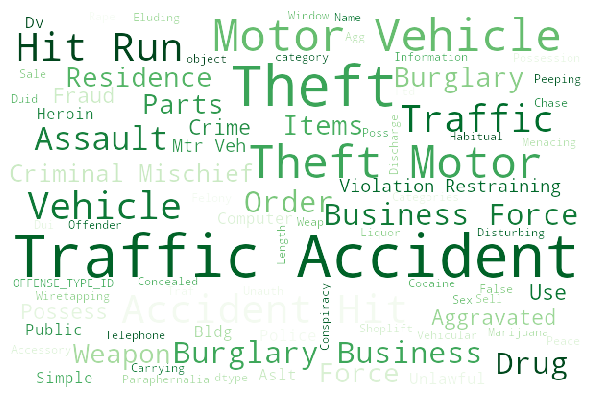

In [29]:
img = WordCloud(width = 600, height = 400,
                background_color = "rgba(255, 255, 255, 0)", 
                mode = "RGBA", colormap = 'Greens', max_words = 200,
                max_font_size = 100, random_state = 13).generate(str(mergedData["OFFENSE_TYPE_ID"]))
plt.figure(figsize=(8,8))
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.imshow(img)
plt.axis('off')
plt.savefig('crimeWordCloud.png', transparent=True)

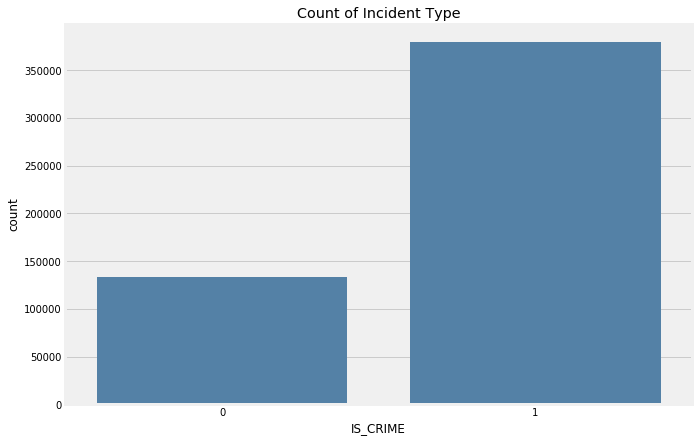

<Figure size 432x288 with 0 Axes>

In [30]:
plt.figure(figsize=(10,7))
a1 = sns.countplot(data = mergedData, x = 'IS_CRIME', color = plot_color)
plt.title('Count of Incident Type')
rotx = a1.set_xticklabels(a1.get_xticklabels(), rotation=0)
sns.set_context('talk')
plt.show()
plt.savefig('incidentCountTypeBar.png', transparent=True)

Break out the datetime data by year, month, day, and hour.

In [31]:
mergedData['FIRST_OCCURRENCE_YEAR'] = mergedData['FIRST_OCCURRENCE_DATE'].dt.year
mergedData['FIRST_OCCURRENCE_MONTH'] = mergedData['FIRST_OCCURRENCE_DATE'].dt.month
mergedData['FIRST_OCCURRENCE_DAY'] = mergedData['FIRST_OCCURRENCE_DATE'].dt.day
mergedData['FIRST_OCCURRENCE_HOUR'] = mergedData['FIRST_OCCURRENCE_DATE'].dt.hour

The barplot below shows incident occurences by year.  A clear upward trend in the data is perceptable from this plot.  The 2019 year is not complete which is why the count is far lower than previous years.

In 2014, there were 83,059 incidents increasing to 93,427 in 2018.  This is an increase of 12.4% over that 5 year span.

In [32]:
crimeDataSorted = crimeData.set_index('FIRST_OCCURRENCE_DATE')
crimeYrSorted = crimeDataSorted.resample('Y')['IS_CRIME','IS_TRAFFIC'].sum()
crimeYrSorted

,IS_CRIME,IS_TRAFFIC
FIRST_OCCURRENCE_DATE,,
2014-12-31,61700,21390
2015-12-31,66048,23363
2016-12-31,67656,23790
2017-12-31,68921,24309
2018-12-31,69145,24327
2019-12-31,46203,16366


<Figure size 1440x720 with 0 Axes>

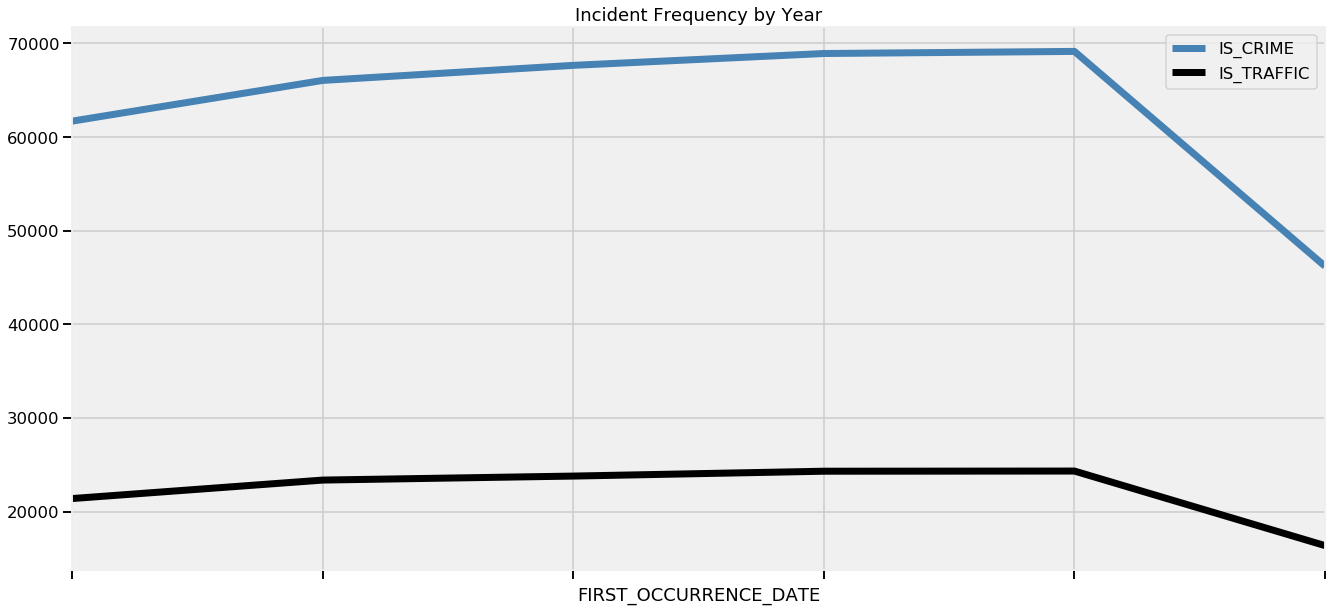

<Figure size 432x288 with 0 Axes>

In [33]:
plt.figure(figsize=(20,10))
ax = crimeYrSorted.plot(figsize=(20,10), color = [plot_color,'black'], linewidth=7.0)
plt.title('Incident Frequency by Year')
rotx = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
sns.set_context('talk')
plt.show()
plt.savefig('incidentFreqCountYearLineCrimeOrTraffic.png', transparent=True)

In [34]:
mergedData_annualCounts = mergedData.groupby('FIRST_OCCURRENCE_YEAR',as_index=False).agg({'INCIDENT_ID':'count'}).copy()
percent_increase = 100 * (mergedData_annualCounts.iat[4,1] - mergedData_annualCounts.iat[0,1]) / mergedData_annualCounts.iat[0,1]
print("The Percent Increase in Incidents from 2014 to 2019 is : {:1.2f} %".format(percent_increase))

The Percent Increase in Incidents from 2014 to 2019 is : 12.48 %


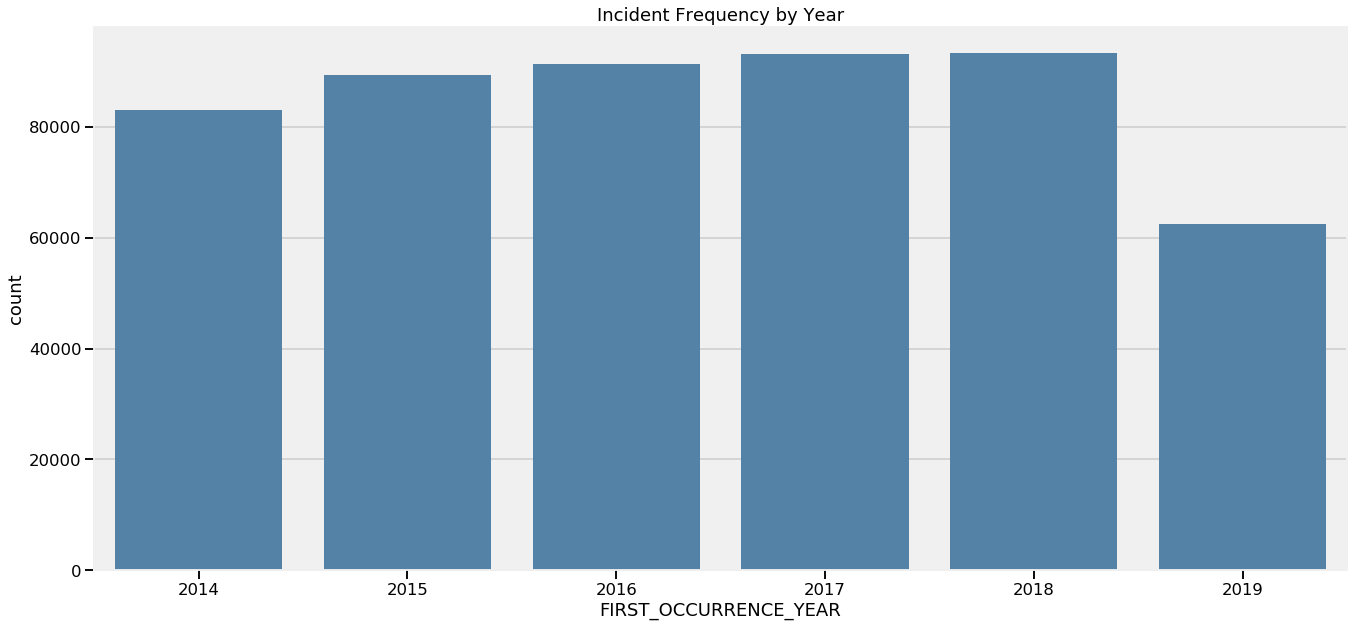

<Figure size 432x288 with 0 Axes>

In [35]:
plt.figure(figsize=(20,10))
ax = sns.countplot(data = mergedData, x = 'FIRST_OCCURRENCE_YEAR', color = plot_color)
plt.title('Incident Frequency by Year')
rotx = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
sns.set_context('talk')
plt.show()
plt.savefig('incidentFreqCountYearBar.png', transparent=True)

In [36]:
mergedDataNo2019 = mergedData[(mergedData['FIRST_OCCURRENCE_YEAR']!=2019)].copy()
mergedDataNo2019[(mergedDataNo2019['FIRST_OCCURRENCE_YEAR']!=2019)].groupby('FIRST_OCCURRENCE_MONTH',as_index=False).agg({'INCIDENT_ID':'count'})
mergedDataNo2019.head()

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,REPORTED_DATE,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,IS_CRIME,IS_TRAFFIC,NEIGHBORHOOD_ID,NBHD_ID,POPULATION_2010,HISPANIC_2010,WHITE_2010,BLACK_2010,NATIVEAM_2010,ASIAN_2010,HAWPACIS_2010,OTHER_2010,TWO_OR_MORE_2010,PCT_HISPANIC,PCT_WHITE,PCT_BLACK,PCT_AMERIND,PCT_ASIAN,PCT_HAW_PACIS,PCT_OTHER_RACE,PCT_TWO_OR_MORE_RACES,HOUSINGUNITS_2010,OCCUPIEDUNITS_2010,VACANTUNITS_2010,MALE,FEMALE,AGE_LESS_5,AGE_5_TO_9,AGE_10_TO_14,AGE_15_TO_17,AGE_18_AND_19,AGE_20,AGE_21,AGE_22_TO_24,AGE_25_TO_29,AGE_30_TO_34,...,FAMILIES,POP_GROUP_QRTRS,GQ_INSTITUTIONALIZED,GQ_CORRECTIONAL_FAC,GQ_JUVENILE_FAC,GQ_NURSING_FAC,GQ_OTHER_INST_FAC,GQ_NONINSTITUTIONAL,GQ_COLLEGEHOUSING,GQ_MILITARYQUARTERS,GQ_OTHER_NONINST,HOUSING_UNITS,OCCUPIED_HU,VACANT_HU,OWNED_W_MORTG_LOAN,OWNED_FREE_CLEAR,RENTED,VACANT_FOR_RENT,VACANT_RENTED_NOT_OCC,VACANT_FOR_SALE,VACANT_SOLD_NOT_OCC,VACANT_SEASONAL,VACANT_MIGRANT_WRKR,VACANT_OTHER,HU_OWNED,OWNED_AGE_15_TO_24,OWNED_AGE_25_TO_34,OWNED_AGE_35_TO_44,OWNED_AGE_45_TO_54,OWNED_AGE_55_TO_59,OWNED_AGE_60_TO_64,OWNED_AGE_65_TO_74,OWNED_AGE_75_TO_84,OWNED_AGE_85_PLUS,HU_RENTED,RENTED_AGE_15_TO_24,RENTED_AGE_25_TO_34,RENTED_AGE_35_TO_44,RENTED_AGE_45_TO_54,RENTED_AGE_55_TO_59,RENTED_AGE_60_TO_64,RENTED_AGE_65_TO_74,RENTED_AGE_75_TO_84,RENTED_AGE_85_PLUS,SHAPE_Length,SHAPE_Area,FIRST_OCCURRENCE_YEAR,FIRST_OCCURRENCE_MONTH,FIRST_OCCURRENCE_DAY,FIRST_OCCURRENCE_HOUR
0,2.018717e+08,2.020000e+14,2399,0,Theft Other,Larceny,2018-01-30 14:54:00,2018-01-30 15:00:00,3137620.0,1679228.0,-105.010932,39.697264,4,412,1,0,Athmar Park,1.0,8898.0,6499.0,1832.0,102.0,67.0,314.0,8.0,14.0,62.0,73.04,20.59,1.15,0.75,3.53,0.09,0.16,0.7,2960.0,2781.0,179.0,4597.0,4301.0,848.0,748.0,651.0,402.0,287.0,121.0,135.0,354.0,774.0,735.0,...,1964.0,5.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2960.0,2781.0,179.0,1336.0,404.0,1041.0,65.0,4.0,50.0,6.0,9.0,0.0,45.0,1740.0,23.0,246.0,392.0,348.0,168.0,153.0,189.0,137.0,84.0,1041.0,96.0,336.0,276.0,178.0,59.0,41.0,30.0,18.0,7.0,0.089156,0.00042,2018,1,30,14
1,2.018253e+09,2.020000e+15,2399,0,Theft Other,Larceny,2018-04-15 17:15:00,2018-04-16 14:59:00,3133706.0,1684099.0,-105.024750,39.710693,4,412,1,0,Athmar Park,1.0,8898.0,6499.0,1832.0,102.0,67.0,314.0,8.0,14.0,62.0,73.04,20.59,1.15,0.75,3.53,0.09,0.16,0.7,2960.0,2781.0,179.0,4597.0,4301.0,848.0,748.0,651.0,402.0,287.0,121.0,135.0,354.0,774.0,735.0,...,1964.0,5.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2960.0,2781.0,179.0,1336.0,404.0,1041.0,65.0,4.0,50.0,6.0,9.0,0.0,45.0,1740.0,23.0,246.0,392.0,348.0,168.0,153.0,189.0,137.0,84.0,1041.0,96.0,336.0,276.0,178.0,59.0,41.0,30.0,18.0,7.0,0.089156,0.00042,2018,4,15,17
2,2.018253e+09,2.020000e+15,5499,0,Traffic Other,All Other Crimes,2018-04-16 08:20:00,2018-04-16 09:50:00,3133895.0,1680332.0,-105.024149,39.700349,4,412,1,0,Athmar Park,1.0,8898.0,6499.0,1832.0,102.0,67.0,314.0,8.0,14.0,62.0,73.04,20.59,1.15,0.75,3.53,0.09,0.16,0.7,2960.0,2781.0,179.0,4597.0,4301.0,848.0,748.0,651.0,402.0,287.0,121.0,135.0,354.0,774.0,735.0,...,1964.0,5.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2960.0,2781.0,179.0,1336.0,404.0,1041.0,65.0,4.0,50.0,6.0,9.0,0.0,45.0,1740.0,23.0,246.0,392.0,348.0,168.0,153.0,189.0,137.0,84.0,1041.0,96.0,336.0,276.0,178.0,59.0,41.0,30.0,18.0,7.0,0.089156,0.00042,2018,4,16,8
3,2.018173e+07,2.020000e+13,5499,0,Traffic Other,All Other Crimes,2018-01-01 19:59:00,2018-01-01 20:25:00,3138193.0,1684241.0,-105.008799,39.711017,4,412,1,0,Athmar Park,1.0,8898.0,6499.0,1832.0,102.0,67.0,314.0,8.0,14.0,62.0,73.04,20.59,1.15,0.75,3.53,0.09,0.16,0.7,2960.0,2781.0,179.0,4597.0,4301.0,848.0,748.0,651.0,402.0,287.0,121.0,135.0,354.0,774.0,735.0,...,1964.0,5.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2960.0,2781.0,179.0,1336.0,404.0,1041.0,65.0,4.0,50.0,6.0,9.0,0.0,45.0,1740.0,23.0,246.0,392.0,348.0,168.0,153.0,189.0,137.0,84.0,1041.0,96.0,336.0,276.0,178.0,59.0,41.0,30.0,18.0,7.0,0.089156,0.00042,2018,1,1,19
4,2.018149

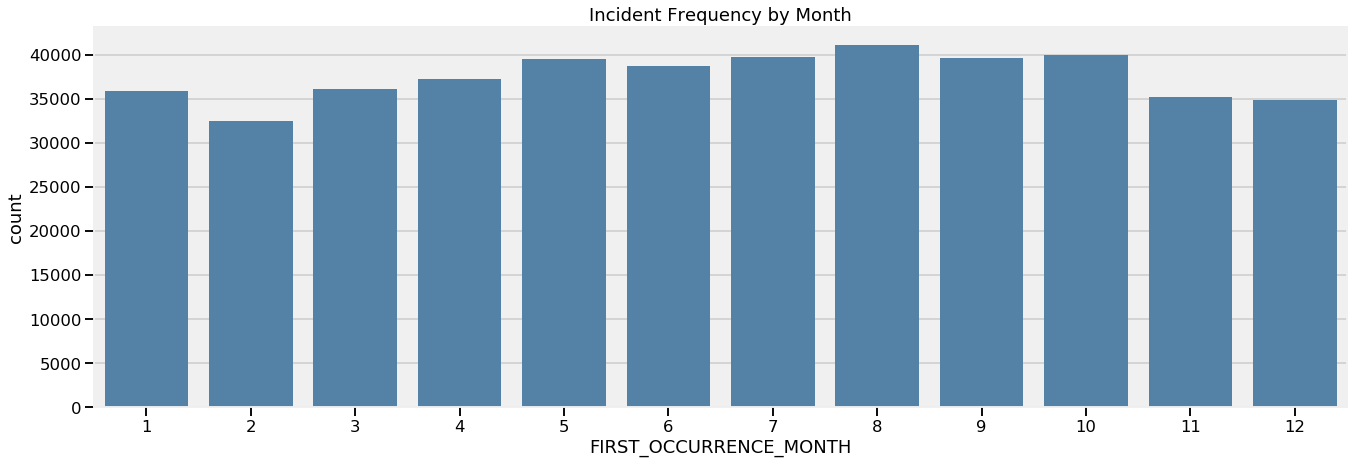

<Figure size 432x288 with 0 Axes>

In [37]:
plt.figure(figsize=(20,7))
ax = sns.countplot(data = mergedDataNo2019, x = 'FIRST_OCCURRENCE_MONTH', color = plot_color)
plt.title('Incident Frequency by Month')
rotx = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
sns.set_context('talk')
plt.show()
plt.savefig('incidentFreqCountMonthBar.png', transparent=True)

In [38]:
incident_total_count = mergedData[(mergedData['IS_CRIME']==1)]['INCIDENT_ID'].count()

crime_jan = mergedData[(mergedData['FIRST_OCCURRENCE_MONTH']==1)&((mergedData['IS_CRIME']==1))]['INCIDENT_ID'].count()
crime_feb = mergedData[(mergedData['FIRST_OCCURRENCE_MONTH']==2)&((mergedData['IS_CRIME']==1))]['INCIDENT_ID'].count()
crime_mar = mergedData[(mergedData['FIRST_OCCURRENCE_MONTH']==3)&((mergedData['IS_CRIME']==1))]['INCIDENT_ID'].count()
crime_apr = mergedData[(mergedData['FIRST_OCCURRENCE_MONTH']==4)&((mergedData['IS_CRIME']==1))]['INCIDENT_ID'].count()
crime_may = mergedData[(mergedData['FIRST_OCCURRENCE_MONTH']==5)&((mergedData['IS_CRIME']==1))]['INCIDENT_ID'].count()
crime_jun = mergedData[(mergedData['FIRST_OCCURRENCE_MONTH']==6)&((mergedData['IS_CRIME']==1))]['INCIDENT_ID'].count()
crime_jul = mergedData[(mergedData['FIRST_OCCURRENCE_MONTH']==7)&((mergedData['IS_CRIME']==1))]['INCIDENT_ID'].count()
crime_aug = mergedData[(mergedData['FIRST_OCCURRENCE_MONTH']==8)&((mergedData['IS_CRIME']==1))]['INCIDENT_ID'].count()
crime_sep = mergedData[(mergedData['FIRST_OCCURRENCE_MONTH']==9)&((mergedData['IS_CRIME']==1))]['INCIDENT_ID'].count()
crime_oct = mergedData[(mergedData['FIRST_OCCURRENCE_MONTH']==10)&((mergedData['IS_CRIME']==1))]['INCIDENT_ID'].count()
crime_nov = mergedData[(mergedData['FIRST_OCCURRENCE_MONTH']==11)&((mergedData['IS_CRIME']==1))]['INCIDENT_ID'].count()
crime_dec = mergedData[(mergedData['FIRST_OCCURRENCE_MONTH']==12)&((mergedData['IS_CRIME']==1))]['INCIDENT_ID'].count()

print("Likelihood for a crime (IS_CRIME = 1) to occur in January is : {:1.6f}".format((crime_jan / incident_total_count)))
print("Likelihood for a crime (IS_CRIME = 1) to occur in February is : {:1.6f}".format((crime_feb / incident_total_count)))
print("Likelihood for a crime (IS_CRIME = 1) to occur in March is : {:1.6f}".format((crime_mar / incident_total_count)))
print("Likelihood for a crime (IS_CRIME = 1) to occur in April is : {:1.6f}".format((crime_apr / incident_total_count)))
print("Likelihood for a crime (IS_CRIME = 1) to occur in May is : {:1.6f}".format((crime_may / incident_total_count)))
print("Likelihood for a crime (IS_CRIME = 1) to occur in June is : {:1.6f}".format((crime_jun / incident_total_count)))
print("Likelihood for a crime (IS_CRIME = 1) to occur in July is : {:1.6f}".format((crime_jul / incident_total_count)))
print("Likelihood for a crime (IS_CRIME = 1) to occur in August is : {:1.6f}".format((crime_aug / incident_total_count)))
print("Likelihood for a crime (IS_CRIME = 1) to occur in September is : {:1.6f}".format((crime_sep / incident_total_count)))
print("Likelihood for a crime (IS_CRIME = 1) to occur in October is : {:1.6f}".format((crime_oct / incident_total_count)))
print("Likelihood for a crime (IS_CRIME = 1) to occur in November is : {:1.6f}".format((crime_nov / incident_total_count)))
print("Likelihood for a crime (IS_CRIME = 1) to occur in December is : {:1.6f}".format((crime_dec / incident_total_count)))

Likelihood for a crime (IS_CRIME = 1) to occur in January is : 0.084665
Likelihood for a crime (IS_CRIME = 1) to occur in February is : 0.074817
Likelihood for a crime (IS_CRIME = 1) to occur in March is : 0.085352
Likelihood for a crime (IS_CRIME = 1) to occur in April is : 0.087720
Likelihood for a crime (IS_CRIME = 1) to occur in May is : 0.091853
Likelihood for a crime (IS_CRIME = 1) to occur in June is : 0.091057
Likelihood for a crime (IS_CRIME = 1) to occur in July is : 0.094510
Likelihood for a crime (IS_CRIME = 1) to occur in August is : 0.097365
Likelihood for a crime (IS_CRIME = 1) to occur in September is : 0.082879
Likelihood for a crime (IS_CRIME = 1) to occur in October is : 0.076811
Likelihood for a crime (IS_CRIME = 1) to occur in November is : 0.066913
Likelihood for a crime (IS_CRIME = 1) to occur in December is : 0.066057


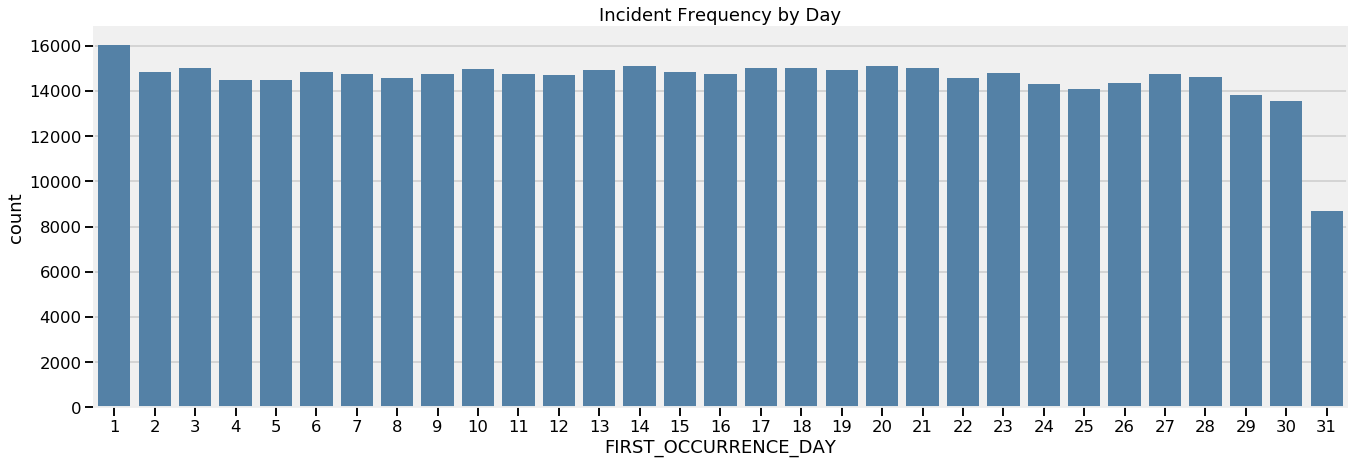

<Figure size 432x288 with 0 Axes>

In [39]:
plt.figure(figsize=(20,7))
ax = sns.countplot(data = mergedDataNo2019, x = 'FIRST_OCCURRENCE_DAY', color = plot_color)
plt.title('Incident Frequency by Day')
rotx = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
sns.set_context('talk')
plt.show()
plt.savefig('incidentFreqCountDayBar.png', transparent=True)

In [40]:
incident_total_count = mergedData[(mergedData['IS_CRIME']==1)]['INCIDENT_ID'].count()

crime_0_to_4 = mergedData[(mergedData['FIRST_OCCURRENCE_HOUR']<4)&((mergedData['FIRST_OCCURRENCE_HOUR']>=0) | (mergedData['IS_CRIME']==1))]['INCIDENT_ID'].count()
crime_4_to_8 = mergedData[(mergedData['FIRST_OCCURRENCE_HOUR']<8)&((mergedData['FIRST_OCCURRENCE_HOUR']>=4) | (mergedData['IS_CRIME']==1))]['INCIDENT_ID'].count()
crime_8_to_12 = mergedData[(mergedData['FIRST_OCCURRENCE_HOUR']<12)&((mergedData['FIRST_OCCURRENCE_HOUR']>=8) | (mergedData['IS_CRIME']==1))]['INCIDENT_ID'].count()
crime_12_to_16 = mergedData[(mergedData['FIRST_OCCURRENCE_HOUR']<16)&((mergedData['FIRST_OCCURRENCE_HOUR']>=12) | (mergedData['IS_CRIME']==1))]['INCIDENT_ID'].count()
crime_16_to_20 = mergedData[(mergedData['FIRST_OCCURRENCE_HOUR']<20)&((mergedData['FIRST_OCCURRENCE_HOUR']>=16)| (mergedData['IS_CRIME']==1))]['INCIDENT_ID'].count()
crime_20_to_24 = mergedData[(mergedData['FIRST_OCCURRENCE_HOUR']<=23)&((mergedData['FIRST_OCCURRENCE_HOUR']>=20)| (mergedData['IS_CRIME']==1))]['INCIDENT_ID'].count()

print("Likelihood for a crime (IS_CRIME = 1) to occur between midnight and 4 AM is : {:1.6f}".format((crime_0_to_4 / incident_total_count)))
print("Likelihood for a crime (IS_CRIME = 1) to occur between 4 AM and 8 AM is : {:1.6f}".format(((crime_4_to_8 - crime_0_to_4) / incident_total_count)))
print("Likelihood for a crime (IS_CRIME = 1) to occur between 8 AM and Noon is : {:1.6f}".format(((crime_8_to_12 - crime_4_to_8) / incident_total_count)))
print("Likelihood for a crime (IS_CRIME = 1) to occur between Noon and 4 PM is : {:1.6f}".format(((crime_12_to_16 - crime_8_to_12) / incident_total_count)))
print("Likelihood for a crime (IS_CRIME = 1) to occur between 4 PM and 8 PM is : {:1.6f}".format(((crime_16_to_20 - crime_12_to_16) / incident_total_count)))
print("Likelihood for a crime (IS_CRIME = 1) to occur between 8 PM and midnight is : {:1.6f}".format(((crime_20_to_24 - crime_16_to_20)/ incident_total_count)))

print(incident_total_count)
print(crime_0_to_4)
print(crime_4_to_8 - crime_0_to_4)
print(crime_8_to_12 -crime_4_to_8)
print(crime_12_to_16 - crime_8_to_12 )
print(crime_16_to_20 - crime_12_to_16)
print(crime_20_to_24 - crime_16_to_20)


Likelihood for a crime (IS_CRIME = 1) to occur between midnight and 4 AM is : 0.166817
Likelihood for a crime (IS_CRIME = 1) to occur between 4 AM and 8 AM is : 0.087225
Likelihood for a crime (IS_CRIME = 1) to occur between 8 AM and Noon is : 0.184446
Likelihood for a crime (IS_CRIME = 1) to occur between Noon and 4 PM is : 0.211406
Likelihood for a crime (IS_CRIME = 1) to occur between 4 PM and 8 PM is : 0.225033
Likelihood for a crime (IS_CRIME = 1) to occur between 8 PM and midnight is : 0.162561
379673
63336
33117
70029
80265
85439
61720


In [41]:
mergedData.groupby('FIRST_OCCURRENCE_HOUR').agg({'INCIDENT_ID':'count'}).sort_values(by='INCIDENT_ID',ascending=False)

,INCIDENT_ID
FIRST_OCCURRENCE_HOUR,
17,33324
16,33308
15,30183
18,29241
12,28003
14,26112
22,25729
19,24587
13,24364


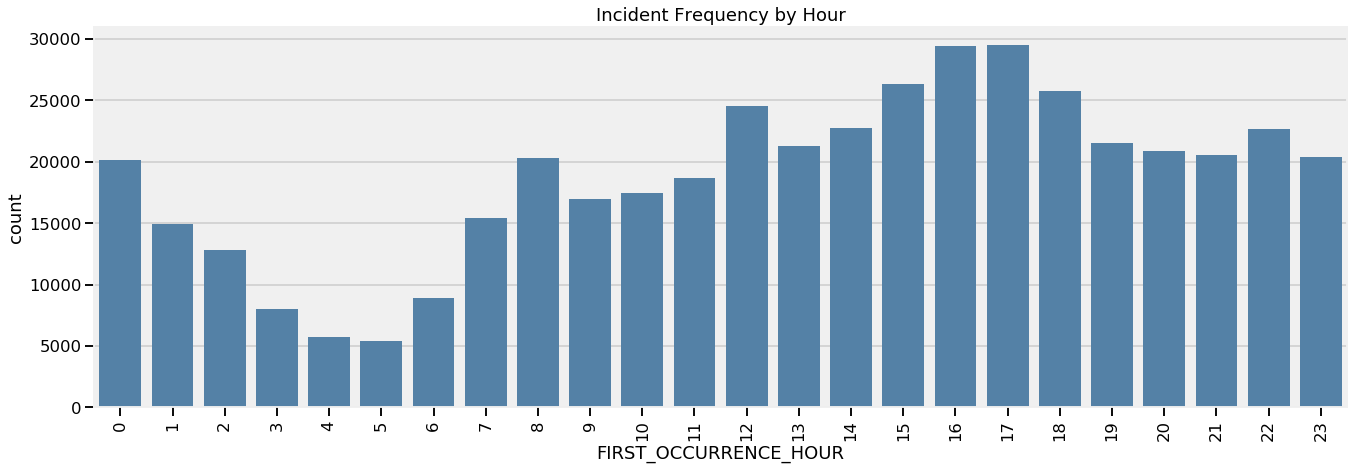

<Figure size 432x288 with 0 Axes>

In [42]:
plt.figure(figsize=(20,7))
ax = sns.countplot(data = mergedDataNo2019, x = 'FIRST_OCCURRENCE_HOUR', color = plot_color)
plt.title('Incident Frequency by Hour')
rotx = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.set_context('talk')
plt.show()
plt.savefig('incidentFreqCountHourBar.png', transparent=False, bbox_inches='tight')

In [43]:
mergedData.groupby(['OFFENSE_CATEGORY_ID','OFFENSE_TYPE_ID']).agg({'INCIDENT_ID':'count'}).groupby(['OFFENSE_CATEGORY_ID']).head().sort_values(by=['OFFENSE_CATEGORY_ID','INCIDENT_ID'],ascending = [True,False])

INCIDENT_ID
OFFENSE_CATEGORY_ID          OFFENSE_TYPE_ID                           
Aggravated Assault           Aggravated Assault                    5678
                             Menacing Felony W Weap                3345
                             Aggravated Assault Dv                 2287
                             Weapon Fire Into Occ Bldg              682
                             Weapon Fire Into Occ Veh               176
All Other Crimes             Agg Aslt Police Weapon                 317
                             Accessory Conspiracy To Crime          147
                             Animal Cruelty To                      147
                             Animal Poss Of Dangerous                15
                             Aslt Agg Police Gun                     10
Arson                        Arson Other                            196
                             Arson Vehicle                          194
                             Arson Residence                        164
                             Arson Business                          73
                             Arson Public Building                   18
Auto Theft                   Theft Of Motor Vehicle               26728
                             Theft Stln Vehicle Trailer             534
                             Theft Stln Veh Const Eqpt               47
Burglary                     Burglary Business By Force            5128
                             Burg Auto Theft Resd No Force          440
                             Burg Auto Theft Resd W Force           174
                             Burg Auto Theft Busn W Force           146
                             Burg Auto Theft Busn No Force           47
Drug Alcohol                 Drug Cocaine Possess                  3131
                             Drug Cocaine Sell                     1505
                             Drug Barbiturate Possess                38
                             Drug Barbiturate Sell                   14
                             Drug Barbiturate Mfr                     2
Larceny                      Theft Bicycle                         8581
                             Theft From Bldg                       5629
                             Theft From Mails                       478
                             Burglary Vending Machine               235
                             Theft From Yards                         1
Murder                       Homicide Other                         251
                             Homicide Family                         27
                             Traf Vehicular Homicide                 25
                             Homicide Negligent                       2
                             Homicide Police By Gun                   2
Other Crimes Against Persons Assault Simple                       14136
                             Assault Dv                            9358
                             Indecent Exposure                      846
                             Assault Police Simple                  760
                             Obscene Material Mfr                     6
Public Disorder              Criminal Mischief Mtr Veh            15531
                             Criminal Mischief Other              13782
                             Disturbing The Peace                  8796
                             Criminal Mischief Graffiti            3158
                             Curfew                                1562
Robbery                      Robbery Business                      1572
                             Robbery Car Jacking                    649
                             Robbery Residence                      419
                             Robbery Purse Snatch W Force           352
                             Robbery Bank                           161
Sexual Assault               Sex Aslt Rape                         2407
                            

In [44]:
mergedData.groupby('OFFENSE_CATEGORY_ID').agg({'INCIDENT_ID':'count'}).sort_values(by='INCIDENT_ID',ascending=False)

,INCIDENT_ID
OFFENSE_CATEGORY_ID,
Traffic Accident,133273
All Other Crimes,92841
Public Disorder,53389
Larceny,52027
Theft From Motor Vehicle,38867
Drug Alcohol,33719
Auto Theft,27309
Burglary,25297
Other Crimes Against Persons,25248


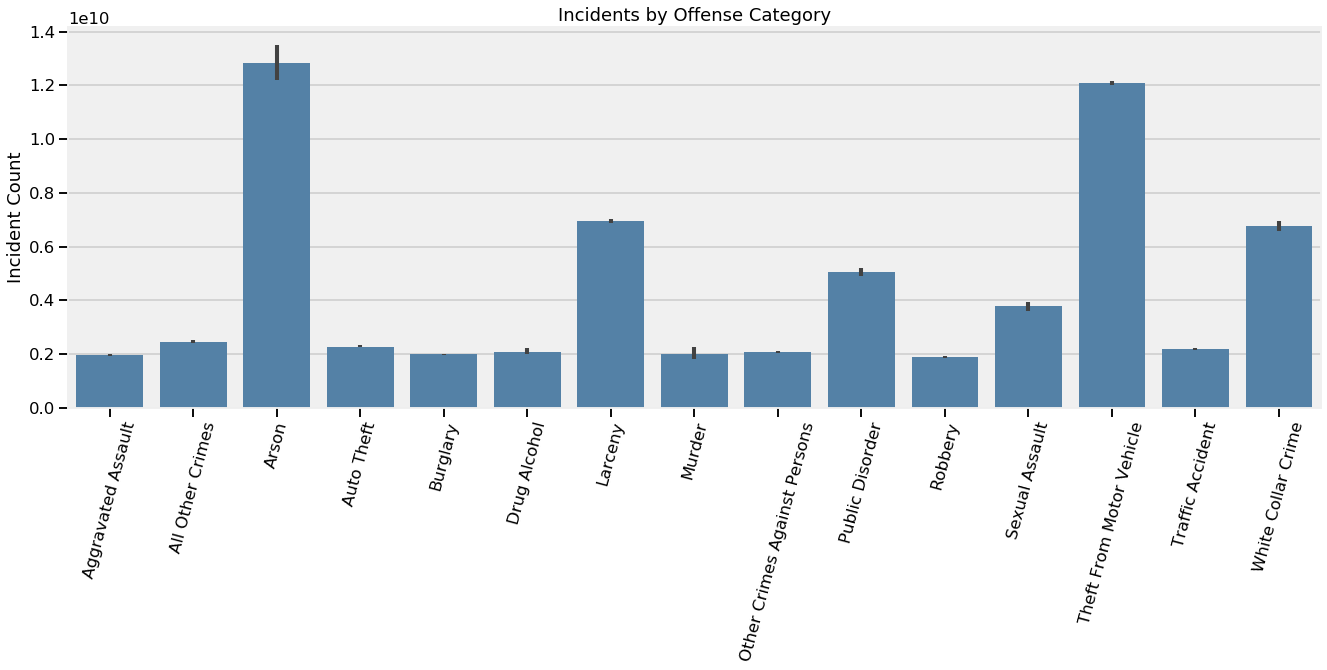

<Figure size 432x288 with 0 Axes>

In [45]:
plt.figure(figsize=(20,7))
ax = sns.barplot(x='OFFENSE_CATEGORY_ID', y="INCIDENT_ID", data=mergedData, color = plot_color) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
plt.title('Incidents by Offense Category')
plt.ylabel("Incident Count")
plt.xlabel("")
sns.set_context('talk')
plt.show()
plt.savefig('incidentCateogryBar.png', transparent=True)

In [46]:
mergedData.groupby('FIRST_OCCURRENCE_MONTH').agg({'INCIDENT_ID':'count'}).sort_values(by='INCIDENT_ID',ascending=False)

,INCIDENT_ID
FIRST_OCCURRENCE_MONTH,
8,49300
7,47803
5,46981
6,46474
4,44356
1,43421
3,43157
9,42504
10,39958


In [47]:
mergedData.groupby(['NEIGHBORHOOD_ID','OFFENSE_CATEGORY_ID']).agg({'INCIDENT_ID':'count'}).groupby(['NEIGHBORHOOD_ID']).head(n=10).sort_values(by=['NEIGHBORHOOD_ID','INCIDENT_ID'],ascending = [True,False])

INCIDENT_ID
NEIGHBORHOOD_ID OFFENSE_CATEGORY_ID                      
Athmar Park     All Other Crimes                     1935
                Public Disorder                       821
                Drug Alcohol                          535
                Auto Theft                            507
                Larceny                               370
                Burglary                              332
                Other Crimes Against Persons          291
                Aggravated Assault                    195
                Arson                                  10
                Murder                                  5
Auraria         All Other Crimes                     1310
                Larceny                               792
                Public Disorder                       452
                Drug Alcohol                          297
                Other Crimes Against Persons          220
                Auto Theft                            104
                Burglary                               94
                Aggravated Assault                     43
                Robbery                                38
                Arson                                   4
Baker           All Other Crimes                     1928
                Larceny                              1612
                Public Disorder                       946
                Drug Alcohol                          636
                Auto Theft                            461
                Burglary                              453
                Other Crimes Against Persons          335
                Aggravated Assault                    171
                Arson                                  16
                Murder                                  5
Barnum          All Other Crimes                     1819
                Public Disorder                       658
                Auto Theft                            363
                Drug Alcohol                          301
                Other Crimes Against Persons          258
                Burglary                              250
                Larceny                               197
                Aggravated Assault                    159
                Arson                                  14
                Murder                                  6
Barnum West     All Other Crimes                      660
                Public Disorder                       326
                Auto Theft                            302
                Drug Alcohol                          284
                Burglary                              178
                Other Crimes Against Persons          131
                Larceny                               125
                Aggravated Assault                     78
                Arson                                   8
                Murder                                  2
...                                                   ...
West Colfax     All Other Crimes                     2872
                Public Disorder                      1438
                Drug Alcohol                          798
                Larceny                               776
                Other Crimes Against Persons          630
                Auto Theft                            591
                Burglary                              499
                Aggravated Assault                    349
                Arson                                  26
                Murder                                 11
West Highland   All Other Crimes                      578
                Larceny                               510
                Public Disorder                       489
                Burglary                              432
                Auto Theft                            323
                Other Crimes Against Persons          157
                Drug Alcohol                

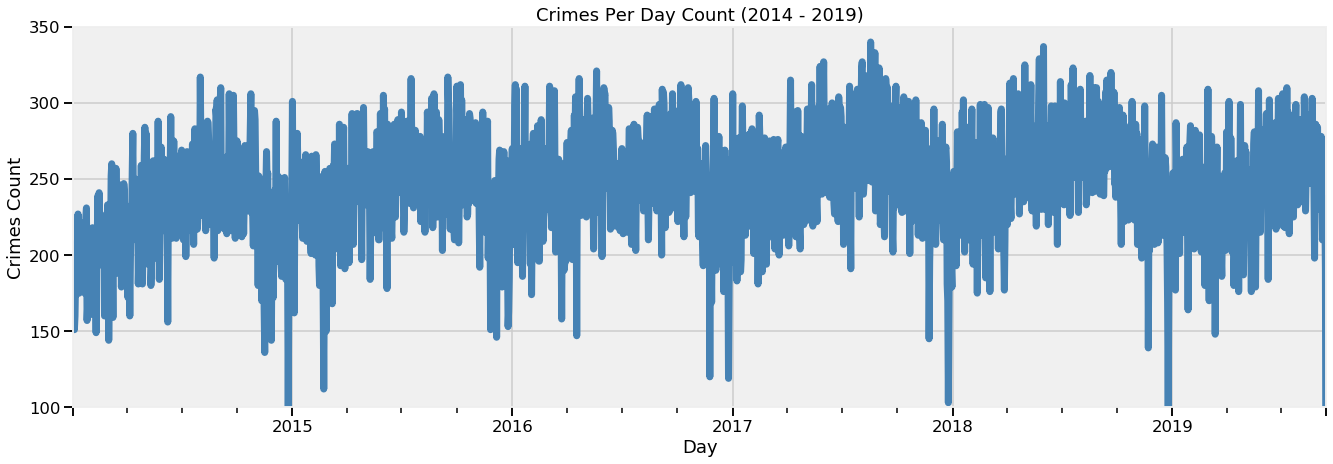

<Figure size 432x288 with 0 Axes>

In [48]:
plt.figure(figsize=(20,7))
crimeData.resample('D').size().plot(legend=False, color = plot_color, linewidth=7.0)
plt.title('Crimes Per Day Count (2014 - 2019)')
plt.xlabel('Day')
plt.ylabel('Crimes Count')
plt.ylim((100,350))
plt.grid(True)
sns.set_context('talk')
plt.show()
plt.savefig('incidentFreqCountDayLine.png', transparent=True)

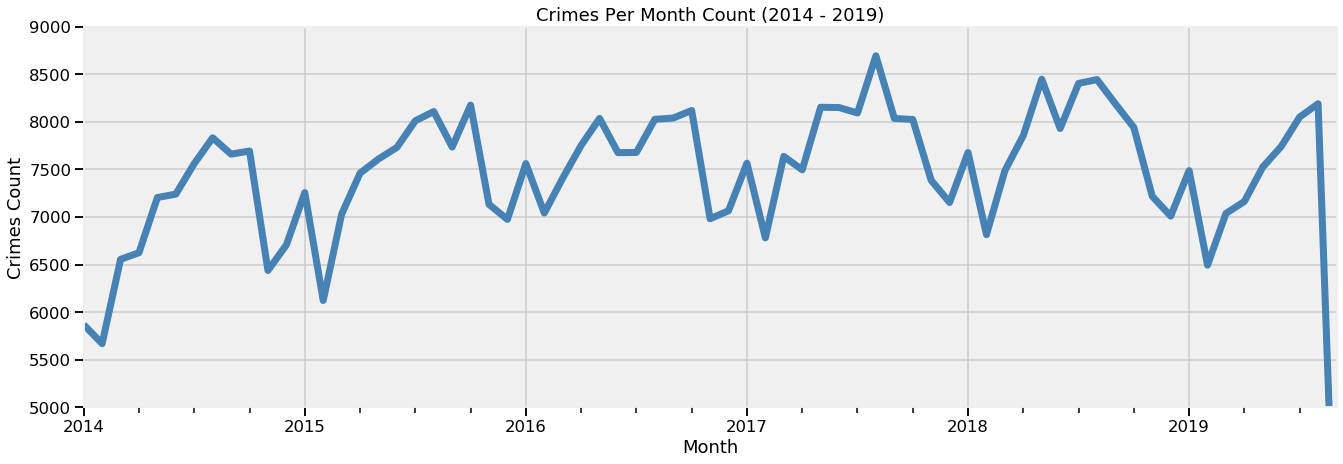

<Figure size 432x288 with 0 Axes>

In [49]:
plt.figure(figsize=(20,7))
crimeData.resample('M').size().plot(legend=False, color = plot_color, linewidth=7.0)
plt.title('Crimes Per Month Count (2014 - 2019)')
plt.xlabel('Month')
plt.ylabel('Crimes Count')
plt.ylim((5000,9000))
plt.grid(True)
sns.set_context('talk')
plt.show()
plt.savefig('incidentFreqCountMonthLine.png', transparent=True)

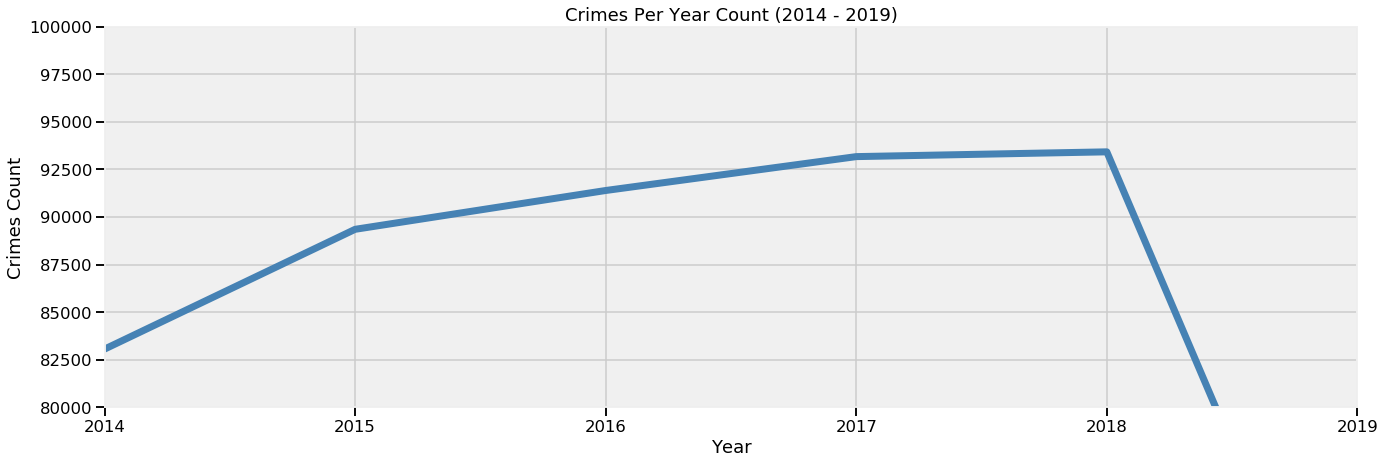

<Figure size 432x288 with 0 Axes>

In [50]:
plt.figure(figsize=(20,7))
crimeData.resample('Y').size().plot(legend=False, color = plot_color, linewidth=7.0)
plt.title('Crimes Per Year Count (2014 - 2019)')
plt.xlabel('Year')
plt.ylabel('Crimes Count')
plt.ylim((80000,100000))
plt.grid(True)
sns.set_context('talk')
plt.show()
plt.savefig('incidentFreqCountDayLine.png', transparent=True)

In [51]:
mergedData.dropna(axis='rows',inplace=True)
mergedData.shape

(461989, 147)

In [52]:
data_crime = mergedData[mergedData['OFFENSE_CATEGORY_ID']=='Murder']
denver_map = folium.Map(location=[39.7, -104.9],
                        zoom_start = 11.4,
                        tiles="cartodbdark_matter")
data_loc= data_crime[['GEO_LAT','GEO_LON']].values
data_loc =data_loc.tolist()
hm = plugins.HeatMap(data_loc)
hm.add_to(denver_map)
denver_map

In [53]:
crimesByNeighborhood = mergedData.groupby('NEIGHBORHOOD_ID',as_index=False).agg({'INCIDENT_ID':'count'}).sort_values(by='INCIDENT_ID',ascending=False)
crimesByNeighborhood.head(n=10)

,NEIGHBORHOOD_ID,INCIDENT_ID
25,Five Points,26633
59,Stapleton,21984
8,Capitol Hill,17536
44,Montbello,17279
2,Baker,14006
40,Lincoln Park,13597
23,East Colfax,13264
75,Westwood,12518
15,Civic Center,12214
62,Union Station,11961


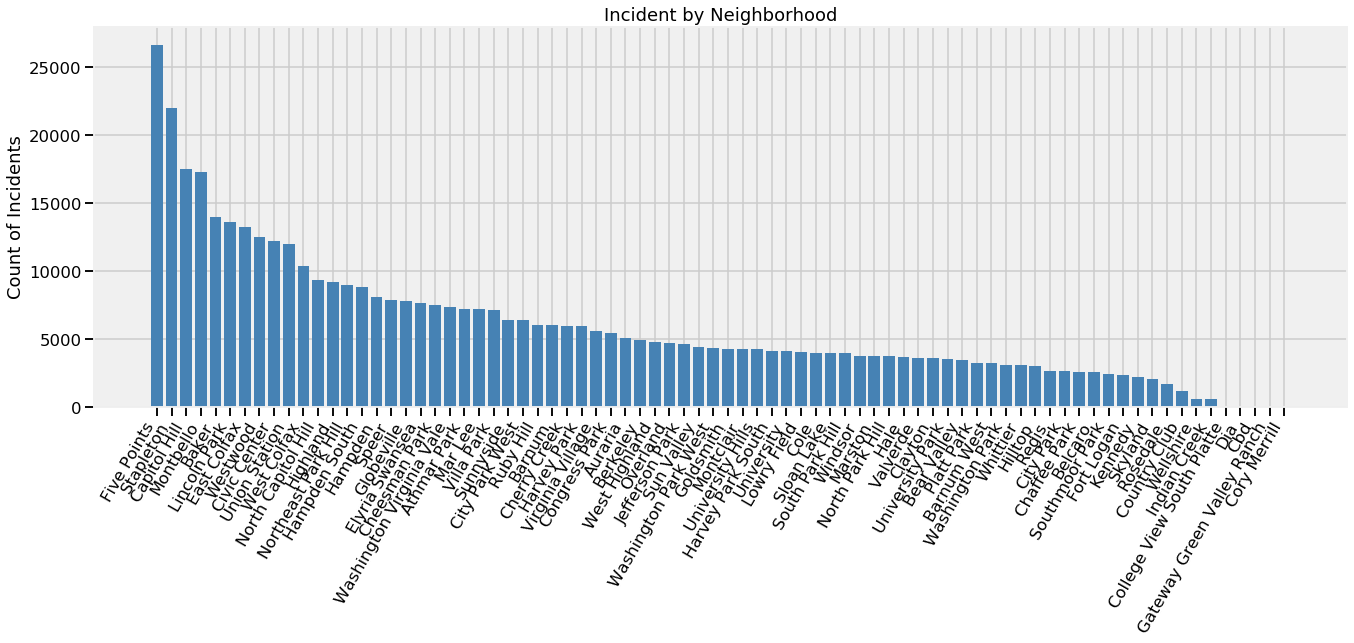

<Figure size 432x288 with 0 Axes>

In [54]:
plt.figure(figsize=(20,7))
crimesByNeighborhood_sorted = np.arange(len(crimesByNeighborhood))
plt.bar(crimesByNeighborhood_sorted, crimesByNeighborhood.INCIDENT_ID, align='center', color = plot_color)
plt.xticks(crimesByNeighborhood_sorted, crimesByNeighborhood.NEIGHBORHOOD_ID)
plt.ylabel('Count of Incidents')
plt.title('Incident by Neighborhood')
plt.xticks(crimesByNeighborhood_sorted, rotation=60, horizontalalignment='right')
sns.set_context('talk')
plt.show()
plt.savefig('incidentCountNeighborhoodBar.png', transparent=True)

In [55]:
population_ethnicity_2010 = censusData[['NEIGHBORHOOD_ID', 'ASIAN_2010', 'BLACK_2010', 'HAWPACIS_2010', 
                             'NATIVEAM_2010', 'WHITE_2010', 'OTHER_2010','POPULATION_2010']].copy()
population_ethnicity_2010 = population_ethnicity_2010.set_index('NEIGHBORHOOD_ID').sort_values(by='POPULATION_2010',ascending=False)
population_ethnicity_2010 = population_ethnicity_2010.drop(['POPULATION_2010'], axis=1).copy()

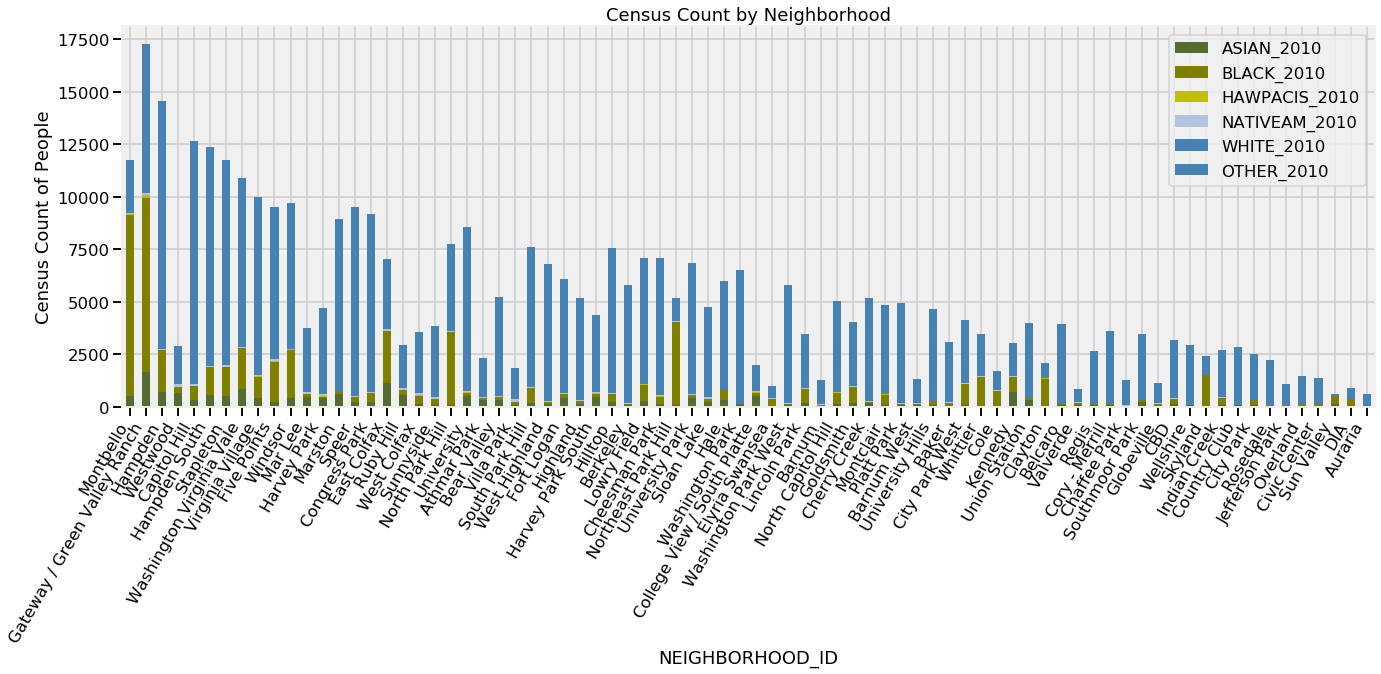

<Figure size 432x288 with 0 Axes>

In [56]:
population_ethnicity_2010.plot.bar(stacked=True, cmap=cmap_green_blue, figsize=(20,7))
plt.ylabel('Census Count of People')
plt.xticks(rotation=60, horizontalalignment='right')
plt.title('Census Count by Neighborhood')
sns.set_context('talk')
plt.show()
plt.savefig('ethnicityCountNeighborhoodBar.png', transparent=True)

In [57]:
population_gender_2010 = censusData[['NEIGHBORHOOD_ID','MALE', 'FEMALE']].copy()
population_gender_2010 = population_gender_2010.set_index('NEIGHBORHOOD_ID')
population_gender_2010.head(n=10)

,MALE,FEMALE
NEIGHBORHOOD_ID,,
Athmar Park,4597,4301
Auraria,352,353
Baker,2565,2314
Barnum,3144,2967
Barnum West,2754,2622
Bear Valley,4396,4493
Belcaro,2009,2163
Berkeley,3884,4228
Capitol Hill,8331,6377


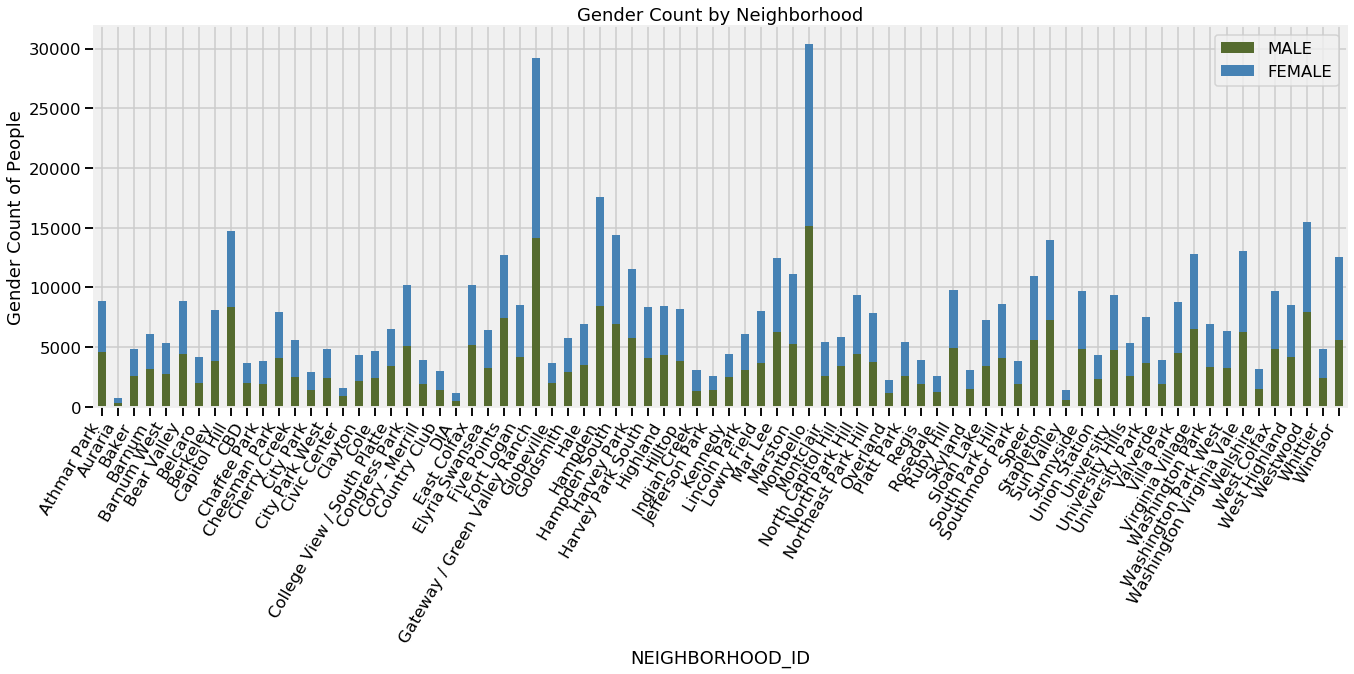

<Figure size 432x288 with 0 Axes>

In [58]:
population_gender_2010.loc[:,['MALE', 'FEMALE']].plot.bar(stacked=True, cmap=cmap_green_blue, figsize=(20,7))
plt.ylabel('Gender Count of People')
plt.xticks(rotation=60, horizontalalignment='right')
plt.title('Gender Count by Neighborhood')
sns.set_context('talk')
plt.show()
plt.savefig('genderCountNeighborhoodBar.png', transparent=True)

In [59]:
population_age_2010 = censusData[['NEIGHBORHOOD_ID','AGE_LESS_5', 'AGE_5_TO_9', 'AGE_10_TO_14','AGE_15_TO_17',
                              'AGE_18_AND_19', 'AGE_20', 'AGE_21', 'AGE_22_TO_24', 'AGE_25_TO_29', 
                              'AGE_30_TO_39', 'AGE_40_TO_49', 'AGE_50_TO_59', 'AGE_60_TO_69', 
                              'AGE_70_TO_79', 'AGE_80_PLUS']].copy()
population_age_2010 = population_age_2010.set_index('NEIGHBORHOOD_ID')
population_age_2010.head()

,AGE_LESS_5,AGE_5_TO_9,AGE_10_TO_14,AGE_15_TO_17,AGE_18_AND_19,AGE_20,AGE_21,AGE_22_TO_24,AGE_25_TO_29,AGE_30_TO_39,AGE_40_TO_49,AGE_50_TO_59,AGE_60_TO_69,AGE_70_TO_79,AGE_80_PLUS
NEIGHBORHOOD_ID,,,,,,,,,,,,,,,
Athmar Park,848,748,651,402,287,121,135,354,774,1487,1123,893,553,291,231
Auraria,1,0,0,6,424,85,34,51,34,21,12,21,12,3,1
Baker,250,213,169,113,78,37,60,225,707,1179,684,615,340,138,71
Barnum,585,612,512,306,202,112,99,243,497,997,803,563,331,162,87
Barnum West,483,437,406,253,170,83,98,253,419,711,696,582,371,271,143


In [60]:
population_age_2010.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, Athmar Park to Windsor
Data columns (total 15 columns):
AGE_LESS_5       78 non-null int64
AGE_5_TO_9       78 non-null int64
AGE_10_TO_14     78 non-null int64
AGE_15_TO_17     78 non-null int64
AGE_18_AND_19    78 non-null int64
AGE_20           78 non-null int64
AGE_21           78 non-null int64
AGE_22_TO_24     78 non-null int64
AGE_25_TO_29     78 non-null int64
AGE_30_TO_39     78 non-null int64
AGE_40_TO_49     78 non-null int64
AGE_50_TO_59     78 non-null int64
AGE_60_TO_69     78 non-null int64
AGE_70_TO_79     78 non-null int64
AGE_80_PLUS      78 non-null int64
dtypes: int64(15)
memory usage: 9.8+ KB


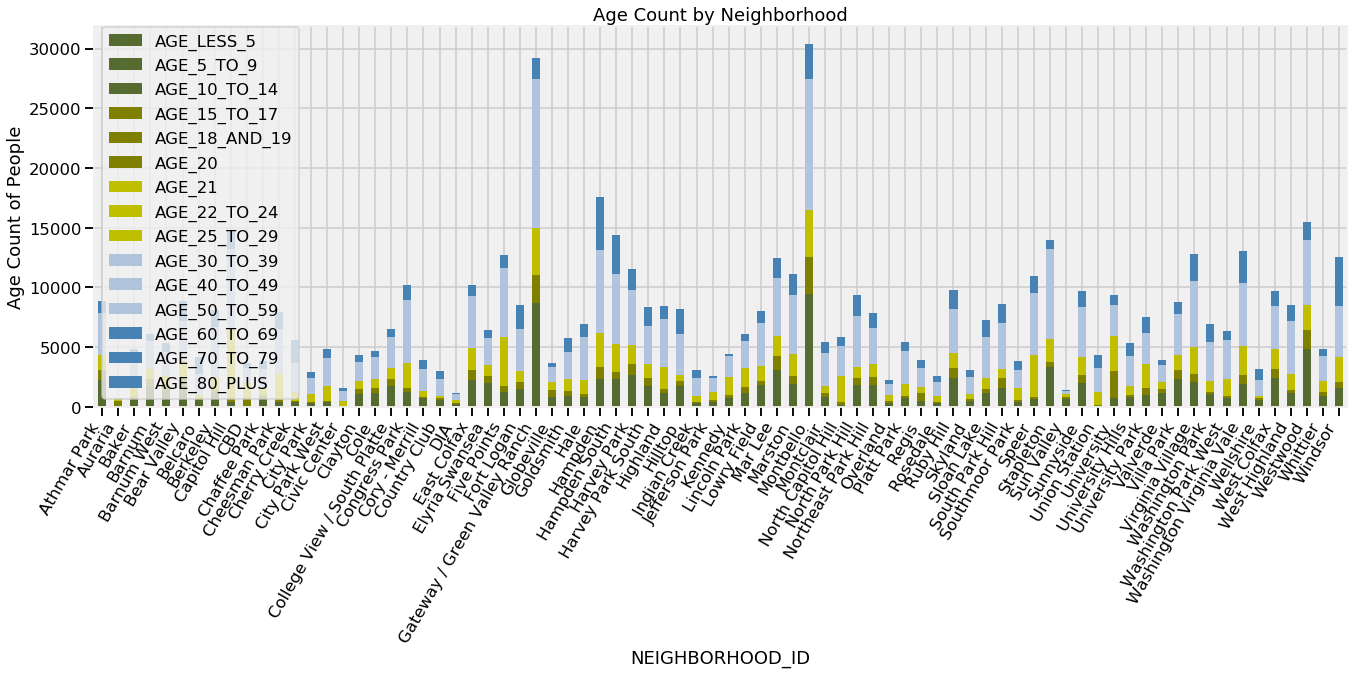

<Figure size 432x288 with 0 Axes>

In [61]:
population_age_2010.loc[:,['AGE_LESS_5', 'AGE_5_TO_9', 'AGE_10_TO_14','AGE_15_TO_17',
                              'AGE_18_AND_19', 'AGE_20', 'AGE_21', 'AGE_22_TO_24', 'AGE_25_TO_29', 
                              'AGE_30_TO_39', 'AGE_40_TO_49', 'AGE_50_TO_59', 'AGE_60_TO_69', 
                              'AGE_70_TO_79', 'AGE_80_PLUS']].plot.bar(stacked=True, cmap=cmap_green_blue, figsize=(20,7))
plt.ylabel('Age Count of People')
plt.xticks(rotation=60, horizontalalignment='right')
plt.title('Age Count by Neighborhood')
sns.set_context('talk')
plt.show()
plt.savefig('ageCountNeighborhoodBar.png', transparent=True)

### Correlation Matrix

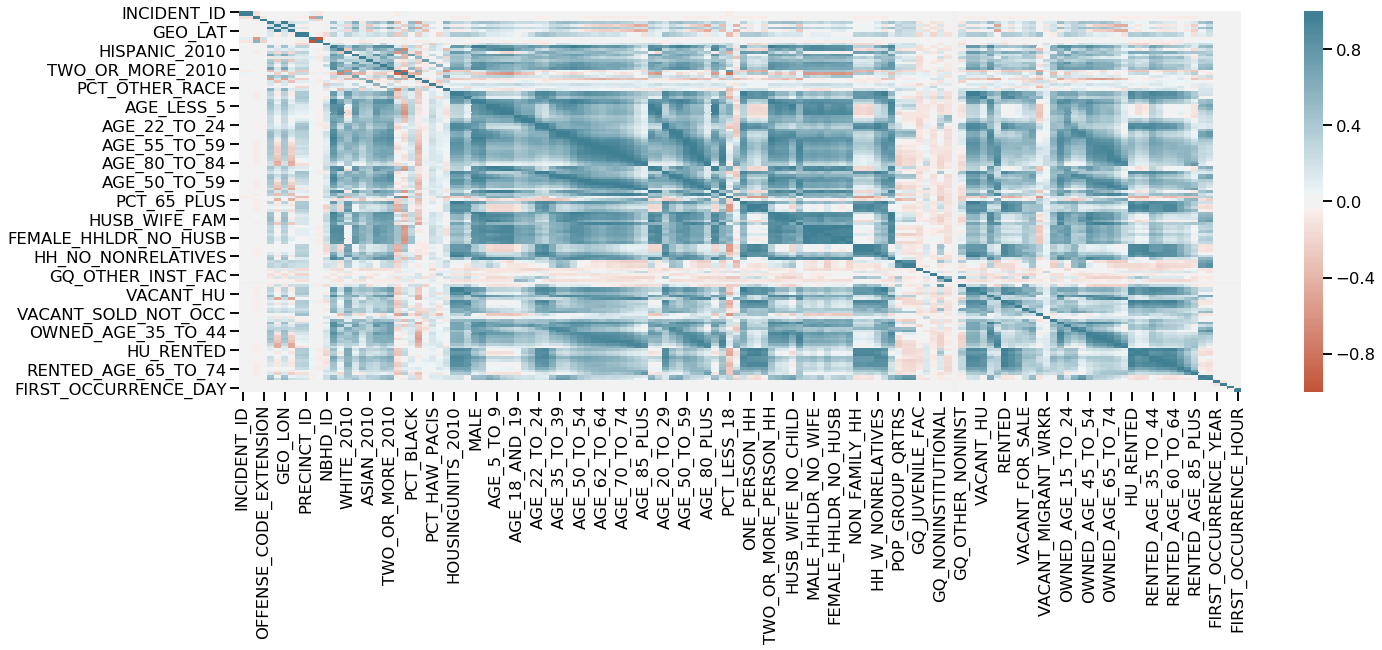

In [62]:
corrMatrix = mergedData.corr()
#sns.set_context("notebook", font_scale=0.9, rc={"lines.linewidth": 3.0})
plt.figure(figsize=(20,7))
#sns.heatmap(corrMatrix, annot=True, fmt='.2f')
sns.heatmap(corrMatrix,vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200))

#corr = data.corr()
#ax = sns.heatmap(
#    corr, 
#    vmin=-1, vmax=1, center=0,
#    cmap=sns.diverging_palette(20, 220, n=200),
#    square=True
#)
#ax.set_xticklabels(
#    ax.get_xticklabels(),
#    rotation=45,
#    horizontalalignment='right'
#);

## Model

## Exploratory Data Analysis

Examine the remaining variables to understand the dataset more deeply and assess potential predictive value.  The research question of interest is, "Is it possible to build a predictive model that uses the census dataset combined with the crime dataset attributes to predict the type of incident captured by the Denver Crime Dataset."

This is a preliminary step in a deeper analysis and modeling question.  Since the crimeData dataset only includes incidents it is not possible at this time to predict events outside of this data set.

Convert the NEIGHBORHOOD_ID to category codes for numerical analysis in KNN model

In [63]:
mergedData['NEIGHBORHOOD_ID'] = mergedData['NEIGHBORHOOD_ID'].astype('category').cat.codes

In [64]:
X = mergedData[(mergedData['IS_CRIME']!=1)].copy()
y = mergedData[(mergedData['IS_CRIME']==0)].copy()

In [65]:
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns


#os_data_X, os_data_y = os.fit_sample(X_train, y_train)

#os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
#os_data_y= pd.DataFrame(data=os_data_y,columns=0)
# we can Check the numbers of our data
#print("length of oversampled data is ",len(os_data_X))
#print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
#print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
#print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
#print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

In [66]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86576 entries, 466118 to 299206
Columns: 147 entries, INCIDENT_ID to FIRST_OCCURRENCE_HOUR
dtypes: category(2), datetime64[ns](2), float64(132), int64(10), int8(1)
memory usage: 96.1 MB


In [67]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(86576, 147)
(37105, 147)
(86576, 147)
(37105, 147)


### KNN Model on the IS_CRIME Attribute

Build a KNN Model with Target and Attribute data based on the merged data set.  The first Model will look at the IS_CRIME variable and attempt to predic when an incident is categorized as a crime versus those incidents where it is purely a traffic incident. This KNN model will be denoted as Model1.

In Model1 I am removing all the attributes which are redundant to the IS_CRIME category (e.g. OFFENSE_ID) because these are clear criminal and non-criminal codes.  A machine learning algorithm which used these attributes would be trivial in nature.

In [68]:
attributeDataModel1 = mergedData.drop(['INCIDENT_ID', 'OFFENSE_ID', 'OFFENSE_CODE', 'INCIDENT_ID', 
                                  'OFFENSE_CODE_EXTENSION', 'OFFENSE_TYPE_ID', 'OFFENSE_CATEGORY_ID', 
                                  'IS_CRIME', 'IS_TRAFFIC', 'FIRST_OCCURRENCE_DATE', 'REPORTED_DATE'], axis=1).copy()
targetDataModel1 = mergedData['IS_CRIME'].copy()
print(attributeDataModel1.shape)
print(targetDataModel1.shape)

(461989, 137)
(461989,)


Split dataset into training set and test set with 30% of the dataset used for testing purposes.

In [69]:
x_crime_train_Model1, x_crime_test_Model1, y_crime_train_Model1, y_crime_test_Model1 = train_test_split(attributeDataModel1, targetDataModel1, test_size=0.3)

Selecting the correct value of K for the K Nearest Neighbor algorihm is important for any given solution to work as best as possible.  If K is too small, noise will unduly influence the result and thus one risks overfitting the problem.  A value of K that is too large becomes computationally expensive and undermines the theory points near are of similar groups.

To find the optimal value of K, I used Cross Validation. Define a range of K values to test and determine the best number of neighbors.  The code below loops through this range and calculates the accuracy.  While accuracy may not be the overall best measure of the quality of a solution, it is useful as relative measure between similar models for the purposes of identifying a K value.

In [70]:
k_range = range(1, 11)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_crime_train_Model1, y_crime_train_Model1)
    y_predicted = knn.predict(x_crime_test_Model1)
    scores.append(metrics.accuracy_score(y_crime_test_Model1, y_predicted))
print(scores)

[0.8073262769035405, 0.7687828740881837, 0.820443443941788, 0.8061862810883352, 0.8248519087714742, 0.8157319422498323, 0.8255662099468243, 0.819209651002547, 0.824426214131619, 0.8194188907407808]


Based on the highest accuracy score above, use that K value (3) for a more detailed evaluation of the model

In [71]:
knn_Model1 = KNeighborsClassifier(n_neighbors=3)
knn_Model1.fit(x_crime_train_Model1, y_crime_train_Model1)
y_crime_predModel1 = knn_Model1.predict(x_crime_test_Model1)

Print out the accuracy, confusion matrix, and classification report.  Put the confusion matrix into a variable for plotting purposes.

In [72]:
print(accuracy_score(y_crime_test_Model1, y_crime_predModel1))
print(confusion_matrix(y_crime_test_Model1, y_crime_predModel1))
print(classification_report(y_crime_test_Model1, y_crime_predModel1))

cm = confusion_matrix(y_crime_test_Model1, y_crime_predModel1)

0.820443443941788
[[23435 13477]
 [11409 90276]]
              precision    recall  f1-score   support

           0       0.67      0.63      0.65     36912
           1       0.87      0.89      0.88    101685

    accuracy                           0.82    138597
   macro avg       0.77      0.76      0.77    138597
weighted avg       0.82      0.82      0.82    138597



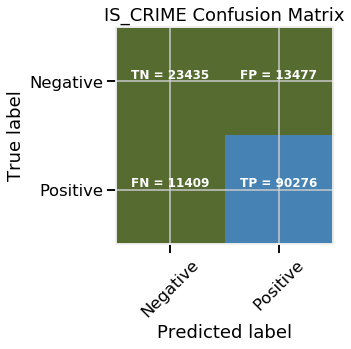

<Figure size 432x288 with 0 Axes>

In [73]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=cmap_green_blue)
classNames = ['Negative','Positive']
plt.title('IS_CRIME Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize=12,
                 ha='center', va='bottom', color='white', fontweight = 'bold')
sns.set_context('talk')
plt.show()
plt.savefig('isCrimeConfusionMatrix.png', transparent=True)

### KNN Model on the OFFENSE_CATEGORY_ID Attribute

As before, build a KNN Model with Target and Attribute data based on the merged data set.  This second Model will look at the OFFENSE_CATEGORY_ID variable and attempt to accurately classify the type of incident that has occurred (e.g. larceny) rather than just is it a traffic incident or a criminal incident. This KNN model will be denoted as Model2.

In Model2 I am removing all the attributes which are redundant to the OFFENSE_CATEGORY_ID category (e.g. OFFENSE_ID) because these are clear criminal and non-criminal codes.

In [74]:
attributeDataModel2 = mergedData.drop(['INCIDENT_ID', 'OFFENSE_ID', 'OFFENSE_CODE', 'INCIDENT_ID', 
                                  'OFFENSE_CODE_EXTENSION', 'OFFENSE_TYPE_ID', 'OFFENSE_CATEGORY_ID', 
                                  'IS_CRIME', 'IS_TRAFFIC', 'FIRST_OCCURRENCE_DATE', 'REPORTED_DATE'], axis=1).copy()
targetDataModel2 = mergedData['OFFENSE_CATEGORY_ID'].copy()
print(attributeDataModel2.shape)
print(targetDataModel2.shape)

(461989, 137)
(461989,)


Split dataset into training set and test set with 30% of the dataset used for testing purposes.

In [75]:
x_crime_train_Model2, x_crime_test_Model2, y_crime_train_Model2, y_crime_test_Model2 = train_test_split(attributeDataModel2, targetDataModel2, test_size=0.3)

Again test a variesty of K values for the best model option.

In [76]:
k_range = range(1, 11)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_crime_train_Model2, y_crime_train_Model2)
    y_predicted = knn.predict(x_crime_test_Model2)
    scores.append(metrics.accuracy_score(y_crime_test_Model2, y_predicted))
print(scores)

[0.36567891079893505, 0.33487737829823155, 0.3674177651752924, 0.3735650843813358, 0.3818769526035917, 0.3830963152160581, 0.3857875711595489, 0.3868770608310425, 0.3875552861894558, 0.38819022056754476]


The highest accuracy score say that a K value of 11 is the best option.

In [77]:
knn_Model2 = KNeighborsClassifier(n_neighbors=11)
knn_Model2.fit(x_crime_train_Model2, y_crime_train_Model2)
y_crime_predModel2 = knn_Model2.predict(x_crime_test_Model2)

Print out the accuracy, confusion matrix, and classification report.  Put the confusion matrix into a variable for plotting purposes.

In [78]:
print(accuracy_score(y_crime_test_Model2, y_crime_predModel2))
print(classification_report(y_crime_test_Model2, y_crime_predModel2))
cm = confusion_matrix(y_crime_test_Model2, y_crime_predModel2)

0.3896260380816324
                              precision    recall  f1-score   support

          Aggravated Assault       0.08      0.04      0.06      3352
            All Other Crimes       0.35      0.44      0.39     25369
                       Arson       0.00      0.00      0.00       169
                  Auto Theft       0.16      0.14      0.15      7385
                    Burglary       0.21      0.18      0.19      7167
                Drug Alcohol       0.39      0.31      0.35      9250
                     Larceny       0.38      0.42      0.40     13270
                      Murder       0.00      0.00      0.00        97
Other Crimes Against Persons       0.18      0.09      0.12      6899
             Public Disorder       0.23      0.20      0.22     14492
                     Robbery       0.07      0.01      0.01      1782
              Sexual Assault       0.00      0.00      0.00         3
    Theft From Motor Vehicle       0.24      0.21      0.22     10650
